# Datenanalyse von Verkehrs- und Wetterdaten



# Projekt: Analyse und Prognose des Verkehrsaufkommens in Zürich

## Grundidee

Ziel dieses Projekts ist es, das **tägliche Verkehrsaufkommen** in Zürich anhand von Wetterdaten, Wochentagen sowie Ferien- und Feiertagskalendern zu analysieren und für die Zukunft vorherzusagen.

Die zentrale Forschungsfrage lautet:

> **Wie stark beeinflussen Wetterbedingungen, Wochentage und Ferien das Verkehrsverhalten in Zürich – und lässt sich daraus eine belastbare Vorhersage ableiten?**

Zur Beantwortung dieser Frage nutzen wir historische Verkehrsdaten, Wetterinformationen sowie Schulferien- und Feiertagsdaten.

---

## Hypothesen

| Nr. | Hypothese                                                                 |
|-----|---------------------------------------------------------------------------|
| H1  | **An Werktagen ist das Verkehrsaufkommen signifikant höher** als an Wochenenden. |
| H2  | **Regen und extreme Temperaturen** führen zu einer **Reduktion des Verkehrsaufkommens**. |
| H3  | Während der **Schulferien oder Feiertage ist das Verkehrsaufkommen geringer**. |
| H4  | Ein **Machine Learning Modell (z. B. Random Forest)** kann den durchschnittlichen Verkehrswert für kommende Tage zuverlässig vorhersagen. |

---

## Datenquellen

- `combined_data_zuerich`: Historische Verkehrsdaten
- `ferienkalender_df`: Informationen zu Schulferien und Feiertagen
- `forecast_data_zuerich`: Wettervorhersage für die nächsten Tage

---

## Vorgehen

1. Daten bereinigen und kombinieren
2. Explorative Datenanalyse (EDA)
3. Feature Engineering (z. B. Wetter, Ferien-Flags, Wochentag)
4. Training & Evaluierung von Regressionsmodellen
5. Prognose des Verkehrsaufkommens für die nächsten 7 Tage

In [1]:
pip install requests pandas matplotlib seaborn

In [2]:
# Global Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import ipywidgets as widgets
import numpy as np
import zipfile
import folium
import io
from pyproj import Transformer
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler


# Wetterdaten
Die Open-Meteo API liefert tägliche Wetterdaten für Zürich i m Zeitraum 01.01.2018 – 31.12.2024.

Die Daten umfassen:
	* Niederschlagssumme (in mm)
	* Tagesminimum & Tagesmaximum der Temperatur (in °C)

Die Daten werden in einem pandas.DataFrame organisiert und können weiterverarbeitet oder visualisiert werden.

In [3]:
# Params
start_date = "2018-01-01"
end_date = "2024-12-31"

# Location
latitude = "47.35953600"
longitude = "8.63564520"
timezone = "Europe/Berlin"
location = "Zürich"

# API-URL
weather_url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&daily=temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max&timezone={timezone}"

# API-Request
weather_response = requests.get(weather_url)

# Check API-Response
if weather_response.status_code == 200:
    weather_data_response = weather_response.json()
    print("Wetterdaten von " + location + " erfolgreich abgerufen!")
    print(weather_data_response)
else:
    print(f"Fehler {weather_response.status_code}: {weather_response.text}")

# create DF from response
daily = weather_data_response.get("daily", {})
weather_data_zuerich = pd.DataFrame({
    'day': daily.get('time', []),
    'precipitation_sum': daily.get('precipitation_sum', []),
    'temperature_min': daily.get('temperature_2m_min', []),
    'temperature_max': daily.get('temperature_2m_max', []),
})

# Konvertiere Datum
weather_data_zuerich['day'] = pd.to_datetime(weather_data_zuerich['day'], errors='coerce')
weather_data_zuerich = weather_data_zuerich.dropna(subset=['day'])  # Entferne fehlerhafte Zeilen
# Print the first two weeks of data
print(weather_data_zuerich.head(14))


Wetterdaten von Zürich erfolgreich abgerufen!
{'latitude': 47.34622, 'longitude': 8.690671, 'generationtime_ms': 214.14470672607422, 'utc_offset_seconds': 7200, 'timezone': 'Europe/Berlin', 'timezone_abbreviation': 'GMT+2', 'elevation': 581.0, 'daily_units': {'time': 'iso8601', 'temperature_2m_max': '°C', 'temperature_2m_min': '°C', 'precipitation_sum': 'mm', 'wind_speed_10m_max': 'km/h'}, 'daily': {'time': ['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12', '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16', '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20', '2018-01-21', '2018-01-22', '2018-01-23', '2018-01-24', '2018-01-25', '2018-01-26', '2018-01-27', '2018-01-28', '2018-01-29', '2018-01-30', '2018-01-31', '2018-02-01', '2018-02-02', '2018-02-03', '2018-02-04', '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09', '2018-02-10', '2018-02-11', 

## Veranschaulichung der Wetterdaten
Nun können wir die vorhandenen Wetterdaten veranschaulichen.

### Der Temperaturwert
Die erste Grafik ist der Verlauft der Tiefst.- und Höchsttemperatur. Dabei sind klar die saisonalen Unterschiede zu erkennen. Der Datensatz ist vollständig und weist keine fehlenden Daten aus.

### Der Niederschlag
In der zweiten Grafik wird der Niederschlag (je nach Temperatur Regen und Schnee) dargestellt. Die Menge an Niederschlag weist deutlich weniger saisonale Schwankungen auf, dafür umso stärkere Ausschläge. Auch dieser Datensatz wirkt plausibel und weist keine fehlenden Daten aus.

### Beschreibung des Wetterdaten-DataFrames `weather_data_zuerich`

| Spalte             | Beschreibung                             |
|--------------------|------------------------------------------|
| `day`              | Datum                                     |
| `precipitation_sum`| Niederschlagsmenge pro Tag (in mm)       |
| `temperature_min`  | tägliches Minimum der Lufttemperatur (°C)|
| `temperature_max`  | tägliches Maximum der Lufttemperatur (°C)|


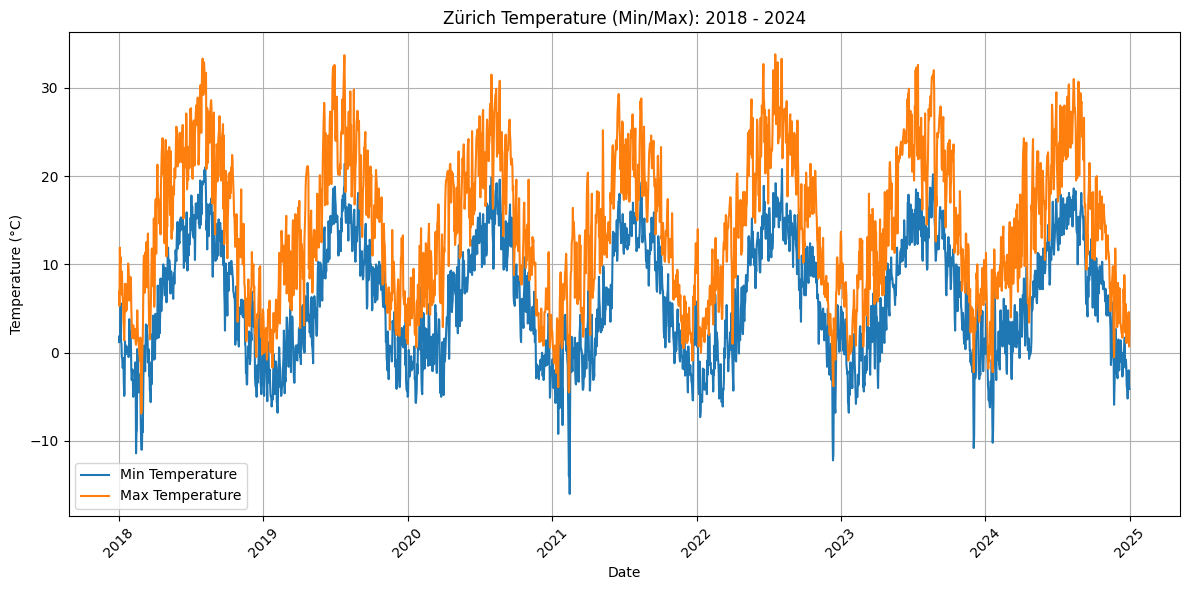

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(weather_data_zuerich['day'], weather_data_zuerich['temperature_min'], label='Min Temperature')
plt.plot(weather_data_zuerich['day'], weather_data_zuerich['temperature_max'], label='Max Temperature')

plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Zürich Temperature (Min/Max): 2018 - 2024')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


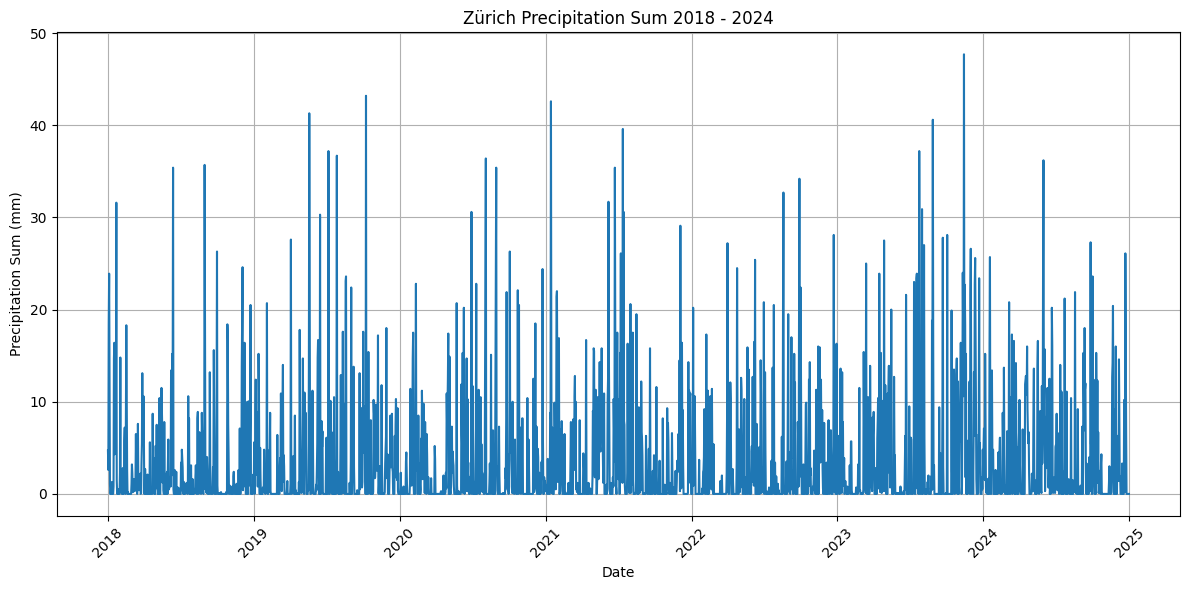

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(weather_data_zuerich['day'], weather_data_zuerich['precipitation_sum'])

plt.xlabel('Date')
plt.ylabel('Precipitation Sum (mm)')
plt.title('Zürich Precipitation Sum 2018 - 2024')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Wettervorhersage Vorhersage für eine Woche
Api-Call um Vorhersage für die nächste Woche zu erhalten.


Mit folgenden Paramter
```
daily temperature_2m_max, temperature_2m_min & precipation_sum
```



In [6]:
forecast_url = f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&daily=temperature_2m_max,temperature_2m_min,precipitation_sum&timezone={timezone}"


# API-Request
forecast_response = requests.get(forecast_url)

# Check API-Response
if forecast_response.status_code == 200:
    forecast_data_response = forecast_response.json()
    print("Wettervorhersage von " + location + " erfolgreich abgerufen!")
    print(forecast_data_response)
else:
    print(f"Fehler {forecast_response.status_code}: {forecast_response.text}")




Wettervorhersage von Zürich erfolgreich abgerufen!
{'latitude': 47.36, 'longitude': 8.639999, 'generationtime_ms': 0.102996826171875, 'utc_offset_seconds': 7200, 'timezone': 'Europe/Berlin', 'timezone_abbreviation': 'GMT+2', 'elevation': 581.0, 'daily_units': {'time': 'iso8601', 'temperature_2m_max': '°C', 'temperature_2m_min': '°C', 'precipitation_sum': 'mm'}, 'daily': {'time': ['2025-06-02', '2025-06-03', '2025-06-04', '2025-06-05', '2025-06-06', '2025-06-07', '2025-06-08'], 'temperature_2m_max': [20.9, 20.3, 22.8, 20.6, 25.2, 22.5, 17.2], 'temperature_2m_min': [15.3, 15.1, 14.0, 13.1, 11.9, 15.9, 11.3], 'precipitation_sum': [16.0, 1.5, 7.3, 0.6, 0.3, 19.8, 2.1]}}


In [7]:
# Prepare forecast data
forecast_data_zuerich = pd.DataFrame({
    'day': pd.to_datetime(forecast_data_response['daily']['time']),
    'precipitation_sum': forecast_data_response['daily']['precipitation_sum'],
    'temperature_min': forecast_data_response['daily']['temperature_2m_min'],
    'temperature_max': forecast_data_response['daily']['temperature_2m_max']
})

forecast_data_zuerich


,day,precipitation_sum,temperature_min,temperature_max
0,2025-06-02,16.0,15.3,20.9
1,2025-06-03,1.5,15.1,20.3
2,2025-06-04,7.3,14.0,22.8
3,2025-06-05,0.6,13.1,20.6
4,2025-06-06,0.3,11.9,25.2
5,2025-06-07,19.8,15.9,22.5
6,2025-06-08,2.1,11.3,17.2


# Schulferien Zürich

- Open Data Stadt Zürich​
- Offizielle Open Data Stelle​

Teil 1:
- Die Schulferiendaten der Stadt Zürich werden direkt von der Open-Data-Plattform heruntergeladen.

Teil 2:
- Die start_date- und end_date-Felder werden in echte Datumsobjekte umgewandelt.
- Nicht relevante Einträge "Schuljahresbeginn" werden entfernt.
- Alle Ferientage werden als tägliche Einzeldaten in zwei getrennten Mengen (Schulferien und Nationale Feiertage) gespeichert.



In [8]:
ferien_url = "https://data.stadt-zuerich.ch/dataset/ssd_schulferien/download/schulferien.csv"

try:
    schulferien_df = pd.read_csv(ferien_url, sep=",")
    print("Schulferiendaten geladen:")
    print(schulferien_df.head())
except Exception as e:
    print(f"Fehler beim Laden der Schulferiendaten: {e}")

Schulferiendaten geladen:
             start_date              end_date  \
0  2018-08-01T00:00:00Z  2018-08-02T00:00:00Z   
1  2018-08-01T00:00:00Z  2018-08-18T00:00:00Z   
2  2018-08-20T00:00:00Z  2018-08-21T00:00:00Z   
3  2018-09-10T00:00:00Z  2018-09-11T00:00:00Z   
4  2018-09-10T00:00:00Z  2018-09-11T00:00:00Z   

                                           summary          created_date  
0                                 Nationalfeiertag  2015-09-04T00:00:00Z  
1               Schulen Stadt Zürich: Sommerferien  2015-10-19T00:00:00Z  
2          Schulen Stadt Zürich: Schuljahresbeginn  2015-08-30T00:00:00Z  
3                                  Knabenschiessen  2015-09-04T00:00:00Z  
4  Schulen Stadt Zürich schulfrei: Knabenschiessen  2015-08-30T00:00:00Z  


## Analyse
Als erstes wird eine Liste mit all den Feriendaten und der Menge erhoben, um zu prüfen ob die Daten komplett sind.

Dabe können wir erkennen, dass die Daten aus dem Jahr 2020 nicht vollständig sind:


```
2020 	366 	103 	7
```

Deshalb werden nun die werte manuell ergänzt.

Als nächsten Schritt möchten wir die Unterschiede wissen.
- Wie viel Einfluss hat ein nationaler Ferientag?
- Wie viel Einfluss haben Schulferien auf den Verkehr?

Die Fragen müssen anhand des Wochentages beantwortet werden, da sonst die Unterschiede von den Differenzen der einzelnen Wochentag überschattet werden.


In [9]:
# Datumsfelder parsen
schulferien_df['start_date'] = pd.to_datetime(schulferien_df['start_date'])
schulferien_df['end_date'] = pd.to_datetime(schulferien_df['end_date'])

# Entferne unerwünschte "pseudo-Ferien"
schulferien_df = schulferien_df[
    ~schulferien_df['summary'].str.contains("Schuljahresbeginn|1. Schultag", case=False, na=False)
]

# Zwei Mengen für Schultage & Feiertage vorbereiten
school_days = set()
national_days = set()

for _, row in schulferien_df.iterrows():
    ferientage = pd.date_range(start=row['start_date'], end=row['end_date']).date
    if "Schulen" in row['summary']:
        school_days.update(ferientage)
    else:
        national_days.update(ferientage)

# Alle Tage im Gesamtzeitraum generieren
start = schulferien_df['start_date'].min().date()
end = schulferien_df['end_date'].max().date()
all_days = pd.date_range(start=start, end=end)

# Umwandlung in Series für .isin()
day_series = pd.Series(all_days)

# DataFrame mit beiden Flags
ferienkalender_df = pd.DataFrame({
    'day': day_series,
    'is_school_holiday': day_series.isin(school_days),
    'is_national_holiday': day_series.isin(national_days)
})

# Vorschau
print(ferienkalender_df.head())

         day  is_school_holiday  is_national_holiday
0 2018-08-01               True                 True
1 2018-08-02               True                 True
2 2018-08-03               True                False
3 2018-08-04               True                False
4 2018-08-05               True                False


<ipython-input-9-d54c3c8506be>:32: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  'is_school_holiday': day_series.isin(school_days),
<ipython-input-9-d54c3c8506be>:33: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  'is_national_holiday': day_series.isin(national_days)


In [10]:
# Liste der Feiertage 2020 Quelle: https://www.feiertagskalender.ch/index.php?geo=3055&klasse=4&jahr=2020&hl=de
feiertage_2020 = [
    '2020-01-01',  # Neujahr
    '2020-01-02',  # Berchtoldstag
    '2020-04-10',  # Karfreitag
    '2020-04-12',  # Ostern
    '2020-04-13',  # Ostermontag
    '2020-04-20',  # Sechseläuten
    '2020-05-01',  # Tag der Arbeit
    '2020-05-21',  # Auffahrt
    '2020-05-31',  # Pfingsten
    '2020-06-01',  # Pfingstmontag
    '2020-08-01',  # Nationalfeiertag Schweiz
    '2020-12-25',  # Weihnachten
    '2020-12-26',  # Stephanstag
]

# In datetime-Objekte umwandeln
feiertage_2020 = pd.to_datetime(feiertage_2020, format='%Y-%m-%d')

# Werte setzen
ferienkalender_df.loc[
    ferienkalender_df['day'].isin(feiertage_2020),
    'is_national_holiday'
] = True

In [11]:
# Group by the year component of the 'day' column
summary = ferienkalender_df.groupby(ferienkalender_df['day'].dt.year).agg(
    Anzahl_Tage=('day', 'count'),
    Schulferientage=('is_school_holiday', 'sum'),
    Nationale_Feiertage=('is_national_holiday', 'sum')
).astype(int)

# Ausgabe der Tabelle
summary

,Anzahl_Tage,Schulferientage,Nationale_Feiertage
day,,,
2018,153,43,9
2019,365,102,18
2020,366,103,17
2021,365,104,18
2022,365,93,20
2023,365,103,20
2024,366,106,18
2025,365,101,25
2026,365,103,24


# Daten aus dem Individualverkehr

Eckwerte zum Datensatz:
- Open Data Stadt Zürich​
- Offizielle Open Data Stelle​
- Datensatz: Daten der Verkehrszählung zum motorisierten Individualverkehr (Stundenwerte)​
- täglich aktualisierten Messwerte zum motorisierten Individualverkehr​
- Verschiedene Messstellen​
- CSV pro Jahr

Teil 1: Datenbeschaffung und -zusammenführung
- CSV-Dateien mit stündlichen Verkehrszähldaten von 2018–2024 werden aus dem Open Data Portal Zürich heruntergeladen.

Teil 2: Aggregation & Visualisierung
- Die stündlichen Zähldaten werden: Pro Zählstelle (ZSID) extrahiert, Tagesweise aggregiert (sum()), Zu einem DataFrame zusammengeführt (merge()). Dies hat den Zweck, um den Datensatz mit den Wetterdaten zu vergleichen, welche nur täglich erhoben werden
- Anschliessend wird der Mittelwert über alle Zählstellen pro Tag berechnet und eine Visualisierung der ersten 2 Wochen wird erzeugt.

Teil 3: Spaltenbereinigung
- Spalten (Zählstellen) mit über 20-mal den Wert 0.0 werden entfernt.
Ziel: Eliminierung von Zählstellen ohne nützliche/falsche Informationen.

Teil 4: Nullwerte behandeln
- Alle 0.0-Werte in den Zählstellenspalten (nicht MessungDatZeit) werden durch NaN ersetzt. Dies ermöglicht eine saubere Differenzierung zwischen "0 Fahrzeuge" und "keine Messung" und somit bessere statistische und ML-Auswertungen.


## Beschreibung des Verkehrsdaten-DataFrames `aggregated_traffic_data`

| Spalte              | Beschreibung                                                                 |
|---------------------|------------------------------------------------------------------------------|
| `day`               | Datum (aggregiert auf Tagesebene)                                            |
| `average_vehicle_count` | Durchschnittliche Anzahl Fahrzeuge pro Stunde (über alle Zählstationen hinweg) |
| `total_vehicle_count`   | Gesamtanzahl der Fahrzeuge pro Tag (Summe aller Stationen und Stunden)       |
| `zs*`     | Anzahl Fahrzeuge pro Zahlstelle                     |



In [12]:
traffic_csv_urls = [
    "https://data.stadt-zuerich.ch/dataset/sid_dav_verkehrszaehlung_miv_od2031/download/sid_dav_verkehrszaehlung_miv_OD2031_2024.csv",
    "https://data.stadt-zuerich.ch/dataset/sid_dav_verkehrszaehlung_miv_od2031/download/sid_dav_verkehrszaehlung_miv_OD2031_2023.csv",
    "https://data.stadt-zuerich.ch/dataset/sid_dav_verkehrszaehlung_miv_od2031/download/sid_dav_verkehrszaehlung_miv_OD2031_2022.csv",
    "https://data.stadt-zuerich.ch/dataset/sid_dav_verkehrszaehlung_miv_od2031/download/sid_dav_verkehrszaehlung_miv_OD2031_2021.csv",
    "https://data.stadt-zuerich.ch/dataset/sid_dav_verkehrszaehlung_miv_od2031/download/sid_dav_verkehrszaehlung_miv_OD2031_2020.csv",
    "https://data.stadt-zuerich.ch/dataset/sid_dav_verkehrszaehlung_miv_od2031/download/sid_dav_verkehrszaehlung_miv_OD2031_2019.csv",
    "https://data.stadt-zuerich.ch/dataset/sid_dav_verkehrszaehlung_miv_od2031/download/sid_dav_verkehrszaehlung_miv_OD2031_2018.csv"
]

traffic_dfs = []
for traffic_csv_url in traffic_csv_urls:
    try:
        traffic_dfs.append(pd.read_csv(traffic_csv_url, low_memory=False))
    except Exception as traffic_csv_err:
        print(f"Error reading {traffic_csv_url}: {traffic_csv_err}")

if traffic_dfs:
    traffic_count_data = pd.concat(traffic_dfs, ignore_index=True)
    print(traffic_count_data.head(10))
else:
    print("No dataframes were created successfully.")


       MSID     MSName  ZSID                              ZSName       Achse  \
0  Z001M001  Unbekannt  Z001  Seestrasse (Strandbad Wollishofen)  Seestrasse   
1  Z001M001  Unbekannt  Z001  Seestrasse (Strandbad Wollishofen)  Seestrasse   
2  Z001M001  Unbekannt  Z001  Seestrasse (Strandbad Wollishofen)  Seestrasse   
3  Z001M001  Unbekannt  Z001  Seestrasse (Strandbad Wollishofen)  Seestrasse   
4  Z001M001  Unbekannt  Z001  Seestrasse (Strandbad Wollishofen)  Seestrasse   
5  Z001M001  Unbekannt  Z001  Seestrasse (Strandbad Wollishofen)  Seestrasse   
6  Z001M001  Unbekannt  Z001  Seestrasse (Strandbad Wollishofen)  Seestrasse   
7  Z001M001  Unbekannt  Z001  Seestrasse (Strandbad Wollishofen)  Seestrasse   
8  Z001M001  Unbekannt  Z001  Seestrasse (Strandbad Wollishofen)  Seestrasse   
9  Z001M001  Unbekannt  Z001  Seestrasse (Strandbad Wollishofen)  Seestrasse   

   HNr      Hoehe      EKoord     NKoord  Richtung  ...  \
0  451  Unbekannt  2683009.89  1243936.2  auswärts  ...   
1

  MessungDatZeit     Z001     Z002     Z003     Z004    Z005  Z006     Z007  \
0     2018-01-01   7622.0   6867.0   4749.0   5694.0  2763.0   0.0   5334.0   
1     2018-01-02   7267.0   7118.0   5285.0   5624.0  3458.0   0.0   6902.0   
2     2018-01-03  10316.0   9545.0   7383.0   8292.0  5610.0   0.0  11743.0   
3     2018-01-04  11064.0  10302.0   8331.0   8837.0  6091.0   0.0  12731.0   
4     2018-01-05  12179.0  11701.0   8896.0   9897.0  6319.0   0.0  13510.0   
5     2018-01-06  10151.0   9963.0   7211.0   7669.0  4708.0   0.0  10235.0   
6     2018-01-07   9032.0   7983.0   5672.0   6357.0  3552.0   0.0   6585.0   
7     2018-01-08  13901.0  12834.0   9978.0  10675.0  7782.0   0.0  14750.0   
8     2018-01-09  14883.0  13629.0  10390.0  11186.0  8060.0   0.0  15434.0   
9     2018-01-10  15180.0  14135.0  10601.0  11479.0  8276.0   0.0  15734.0   

      Z008     Z009  ...  Z104  Z105  Z106  Z107  Z108  Z109  Z110  Z111  \
0   5671.0   5331.0  ...   0.0   0.0   0.0   0.0   0.0

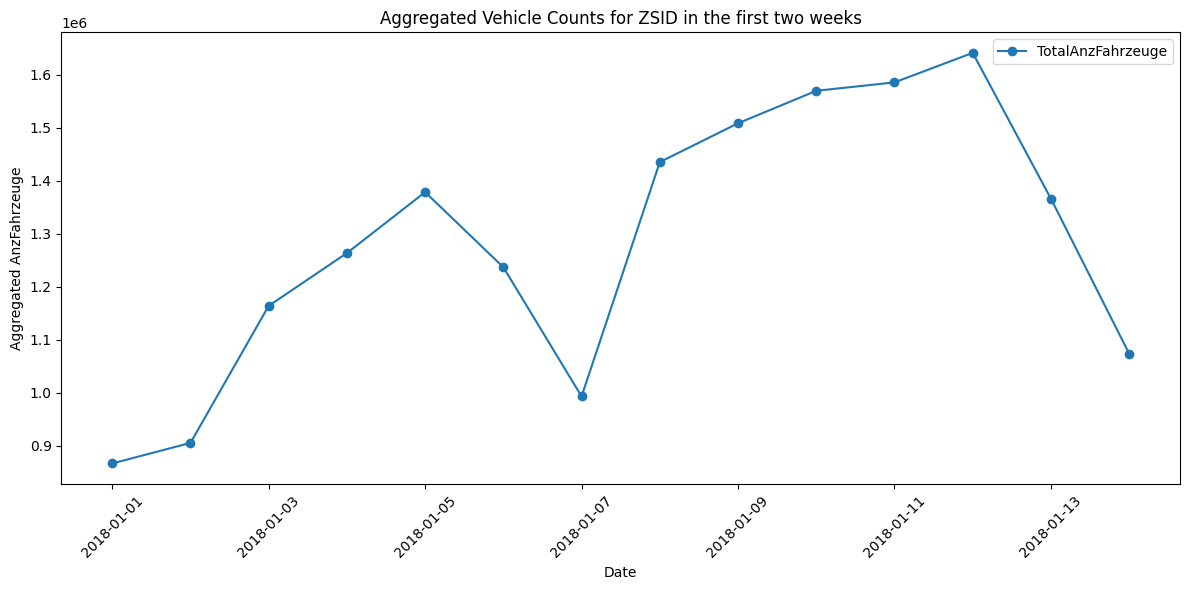

In [13]:
# ZS is the abbreviation for Zählstelle --> trafficcounter

aggregated_traffic_data = pd.DataFrame()
all_zsids = traffic_count_data['ZSID'].unique()

for zsid in all_zsids:
    # Filter for the current ZSID
    hourly_traffic_count = traffic_count_data[traffic_count_data['ZSID'] == zsid].copy()

    # Convert MessungDatZeit to datetime objects
    hourly_traffic_count['MessungDatZeit'] = pd.to_datetime(hourly_traffic_count['MessungDatZeit'])

    # Aggregate data by date
    daily_traffic_data = hourly_traffic_count.groupby(hourly_traffic_count['MessungDatZeit'].dt.date)['AnzFahrzeuge'].sum()
    daily_traffic_data = daily_traffic_data.reset_index()
    daily_traffic_data.columns = ['MessungDatZeit', zsid]

    if aggregated_traffic_data.empty:
      aggregated_traffic_data = daily_traffic_data
    else:
      aggregated_traffic_data = pd.merge(aggregated_traffic_data, daily_traffic_data, on='MessungDatZeit', how='outer')

# Fill NaN values with 0
aggregated_traffic_data.fillna(0, inplace=True)


# Calculate the total AnzFahrzeuge for each date
aggregated_traffic_data['TotalAnzFahrzeuge'] = aggregated_traffic_data[all_zsids].sum(axis=1)

# Get the first two weeks of data
start_date = aggregated_traffic_data['MessungDatZeit'].min()
end_date = start_date + pd.Timedelta(days=13)
first_two_weeks_data = aggregated_traffic_data[(aggregated_traffic_data['MessungDatZeit'] >= start_date) & (aggregated_traffic_data['MessungDatZeit'] <= end_date)]

# List of ZSID columns (excluding 'MessungDatZeit' and 'TotalAnzFahrzeuge')
zsids = [col for col in aggregated_traffic_data.columns if col.startswith('Z') and col != 'TotalAnzFahrzeuge']

# Calculate the average AnzFahrzeuge for each date
aggregated_traffic_data['AverageAnzFahrzeuge'] = aggregated_traffic_data[zsids].mean(axis=1)

# Print the first 10 lines of the aggregated data
print(aggregated_traffic_data.head(10))


# Create the plot for the first two weeks
plt.figure(figsize=(12, 6))
plt.plot(first_two_weeks_data['MessungDatZeit'], first_two_weeks_data['TotalAnzFahrzeuge'], label='TotalAnzFahrzeuge', marker='o')


plt.xlabel("Date")
plt.ylabel("Aggregated AnzFahrzeuge")
plt.title("Aggregated Vehicle Counts for ZSID in the first two weeks")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
# Find columns where more than 20 values are 0.0
zero_counts = (aggregated_traffic_data == 0.0).sum()
columns_to_drop = zero_counts[zero_counts > 20].index.tolist()

# Drop the identified columns
aggregated_traffic_data_cleaned = aggregated_traffic_data.drop(columns=columns_to_drop)

print("Original number of columns:", aggregated_traffic_data.shape[1])
print("Columns dropped:", columns_to_drop)
print("Number of columns after dropping:", aggregated_traffic_data_cleaned.shape[1])
print(aggregated_traffic_data_cleaned.head())

Original number of columns: 112
Columns dropped: ['Z001', 'Z006', 'Z007', 'Z011', 'Z015', 'Z019', 'Z021', 'Z022', 'Z024', 'Z029', 'Z034', 'Z036', 'Z037', 'Z045', 'Z046', 'Z050', 'Z051', 'Z052', 'Z060', 'Z065', 'Z066', 'Z070', 'Z071', 'Z073', 'Z077', 'Z079', 'Z080', 'Z084', 'Z085', 'Z086', 'Z088', 'Z090', 'Z092', 'Z093', 'Z096', 'Z098', 'Z099', 'Z100', 'Z101', 'Z102', 'Z103', 'Z104', 'Z105', 'Z106', 'Z107', 'Z108', 'Z109', 'Z110', 'Z111']
Number of columns after dropping: 63
  MessungDatZeit     Z002    Z003    Z004    Z005     Z008     Z009     Z010  \
0     2018-01-01   6867.0  4749.0  5694.0  2763.0   5671.0   5331.0  12333.0   
1     2018-01-02   7118.0  5285.0  5624.0  3458.0   6456.0   6017.0  13727.0   
2     2018-01-03   9545.0  7383.0  8292.0  5610.0   8798.0   9819.0  18013.0   
3     2018-01-04  10302.0  8331.0  8837.0  6091.0   9485.0  10657.0  19054.0   
4     2018-01-05  11701.0  8896.0  9897.0  6319.0  10343.0  11442.0  20769.0   

      Z012     Z013  ...    Z081     Z08

In [15]:
# Replace 0.0 values with NaN in all columns except 'MessungDatZeit'
cols_to_clean = aggregated_traffic_data_cleaned.columns.difference(['MessungDatZeit'])
aggregated_traffic_data_cleaned[cols_to_clean] = aggregated_traffic_data_cleaned[cols_to_clean].replace(0.0, np.nan)

aggregated_traffic_data_cleaned = aggregated_traffic_data_cleaned.rename(columns={'MessungDatZeit': 'day'})

# aggregated_traffic_data_cleaned.dropna(inplace=True)

print(aggregated_traffic_data_cleaned.head())

          day     Z002    Z003    Z004    Z005     Z008     Z009     Z010  \
0  2018-01-01   6867.0  4749.0  5694.0  2763.0   5671.0   5331.0  12333.0   
1  2018-01-02   7118.0  5285.0  5624.0  3458.0   6456.0   6017.0  13727.0   
2  2018-01-03   9545.0  7383.0  8292.0  5610.0   8798.0   9819.0  18013.0   
3  2018-01-04  10302.0  8331.0  8837.0  6091.0   9485.0  10657.0  19054.0   
4  2018-01-05  11701.0  8896.0  9897.0  6319.0  10343.0  11442.0  20769.0   

      Z012     Z013  ...    Z081     Z082     Z083    Z087    Z089    Z091  \
0   7923.0   5157.0  ...  6561.0   5911.0  13598.0  6741.0  2353.0  4442.0   
1   8227.0   6326.0  ...  6154.0   5820.0  13029.0  6101.0  3641.0  4252.0   
2  11610.0   9779.0  ...  8271.0   6734.0  15172.0  7972.0  4391.0  6929.0   
3  12194.0  10406.0  ...  8896.0   7310.0  15968.0  8521.0  4777.0  7600.0   
4  13235.0  11060.0  ...  9680.0  13698.0  17803.0  9450.0  5028.0  8301.0   

     Z095     Z097  TotalAnzFahrzeuge  AverageAnzFahrzeuge  
0  2371

In [16]:
# Sicherstellen, dass das Datum im richtigen Format ist
aggregated_traffic_data_cleaned['day'] = pd.to_datetime(aggregated_traffic_data_cleaned['day'])
weather_data_zuerich['day'] = pd.to_datetime(weather_data_zuerich['day'])

# Merge the two dataframes based on the 'day' column
combined_data_zuerich = pd.merge(weather_data_zuerich, aggregated_traffic_data_cleaned, on='day', how='left')

# Umbennend von Zeilen
combined_data_zuerich = combined_data_zuerich.rename(columns={'TotalAnzFahrzeuge': 'total_vehicle_count'})
combined_data_zuerich = combined_data_zuerich.rename(columns={'AverageAnzFahrzeuge': 'average_vehicle_count'})
# Merge mit Ferienkalender
combined_data_zuerich = pd.merge(combined_data_zuerich, ferienkalender_df, on='day', how='left')

# Neue Spalte für den Wochentag
combined_data_zuerich['weekday'] = combined_data_zuerich['day'].dt.day_name()

# Spaltenreihenfolge anpassen: beide Ferien-Flags direkt nach 'day'
cols = combined_data_zuerich.columns.tolist()

# Entferne die beiden Spalten vorübergehend
cols.remove('is_school_holiday')
cols.remove('is_national_holiday')

# Füge sie nach 'day' wieder ein
day_index = cols.index('day') + 1
cols.insert(day_index, 'is_national_holiday')
cols.insert(day_index, 'is_school_holiday')

# Neue Spaltenreihenfolge anwenden
combined_data_zuerich = combined_data_zuerich[cols]

# Filter: nur Daten ab dem 1. August 2018 behalten
combined_data_zuerich = combined_data_zuerich[
    combined_data_zuerich['day'] >= pd.to_datetime("2018-08-01")
]

# Vorschau
print(combined_data_zuerich.head())


           day is_school_holiday is_national_holiday  precipitation_sum  \
212 2018-08-01              True                True                1.6   
213 2018-08-02              True                True                0.6   
214 2018-08-03              True               False                0.0   
215 2018-08-04              True               False                0.0   
216 2018-08-05              True               False                0.1   

     temperature_min  temperature_max     Z002    Z003    Z004    Z005  ...  \
212             19.2             33.3   7760.0  5141.0  5904.0  3078.0  ...   
213             19.4             29.2  11138.0  8149.0  8868.0  6362.0  ...   
214             19.4             32.4  11339.0  8195.0  9338.0  7298.0  ...   
215             19.3             32.9   8652.0  6260.0  6885.0  4999.0  ...   
216             20.7             31.9   7912.0  5521.0  5653.0  3582.0  ...   

        Z082     Z083     Z087    Z089    Z091    Z095     Z097  \
212  12

## Analyse
Die Verkehrsdaten können verschieden analysisert und visualisiert werden. Wir können die einzelnen Zählstellen nach Volumen oder Varianz sortieren. Beides erlaubt uns wertvolle Einsicht in den Verkehrsstrom der Stadt.


In [17]:
# Zählstellenspalten extrahieren (z. B. Z001, Z002, ..., Znnn)
zaehlstellen_spalten = [col for col in aggregated_traffic_data_cleaned.columns if col.startswith("Z")]

# Deskriptive Statistik
stats = aggregated_traffic_data_cleaned[zaehlstellen_spalten].describe().transpose()
stats.head(10)

,count,mean,std,min,25%,50%,75%,max
Z002,2549.0,12267.945469,2880.611183,2565.0,10418.00,12452.0,13874.00,21915.0
Z003,2548.0,9670.048273,2150.987751,2067.0,8189.75,9970.0,11268.25,14170.0
Z004,2549.0,10231.785798,2046.564686,3040.0,8766.00,10885.0,11805.00,18070.0
Z005,2549.0,7298.069831,1951.120004,366.0,5777.00,7979.0,8855.00,10834.0
Z008,2549.0,10764.616320,2277.880046,3652.0,9294.00,11361.0,12482.00,15119.0
Z009,2549.0,11694.856414,2874.980877,3674.0,9714.00,12822.0,13880.00,16380.0
Z010,2549.0,21457.618674,4185.225129,6084.0,19060.00,22878.0,24454.00,28540.0
Z012,2549.0,14033.499804,2366.862315,5535.0,12429.00,14922.0,15887.00,17894.0
Z013,2549.0,12878.128678,3336.484265,3527.0,10220.00,13912.0,15487.00,19343.0
Z014,2549.0,8184.316987,2290.560878,55.0,6681.00,8389.0,9580.00,14052.0


In [18]:
# Top 10 Zählstellen mit höchstem Durchschnittsverkehr
top_mean = stats['mean'].sort_values(ascending=False).head(10)
print(top_mean)

Z038    47631.464678
Z026    46938.876422
Z072    43741.477032
Z031    40228.437328
Z033    34705.731841
Z068    28870.484884
Z076    27535.292501
Z040    24297.205651
Z016    22731.276772
Z010    21457.618674
Name: mean, dtype: float64


In [19]:
# Zählstellen mit größter Standardabweichung
top_std = stats['std'].sort_values(ascending=False).head(10)
print(top_std)

Z038    7522.671307
Z026    7436.212733
Z031    6863.839706
Z076    6080.612264
Z033    5709.471420
Z016    5533.448784
Z072    5321.478376
Z044    4932.133446
Z040    4750.942140
Z020    4704.872072
Name: std, dtype: float64


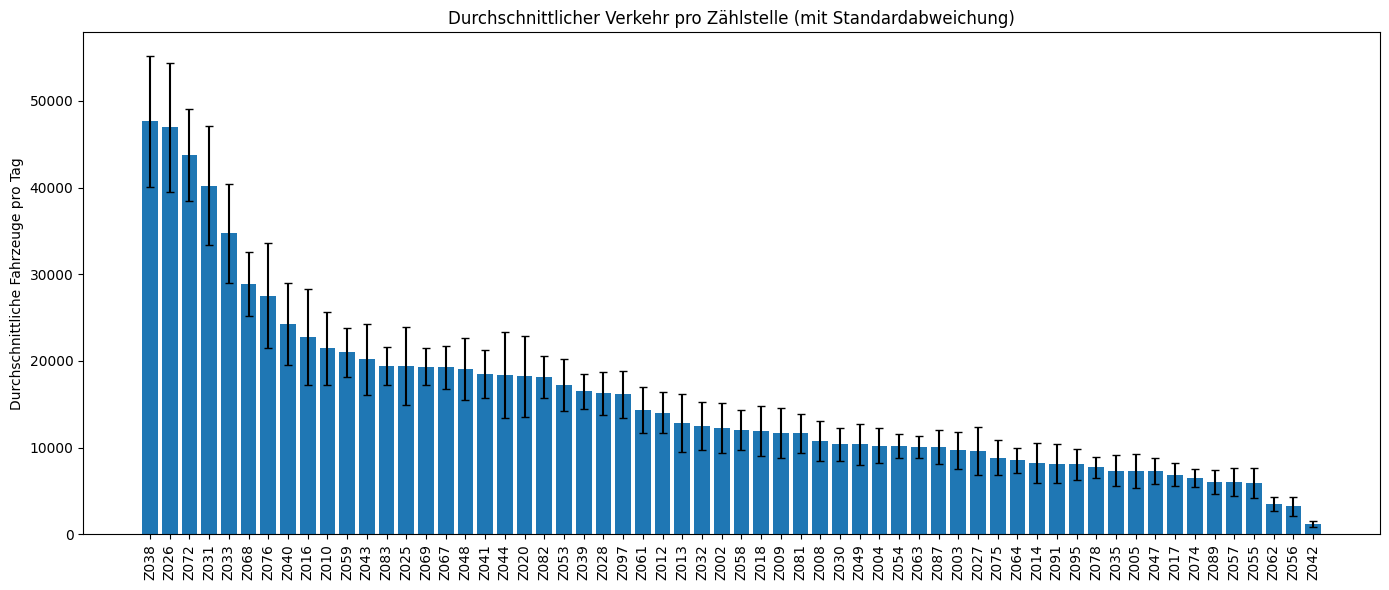

In [20]:
# Sortieren nach Mittelwert
sorted_stats = stats.sort_values('mean', ascending=False)

plt.figure(figsize=(14, 6))
plt.bar(sorted_stats.index, sorted_stats['mean'], yerr=sorted_stats['std'], capsize=3)
plt.xticks(rotation=90)
plt.ylabel("Durchschnittliche Fahrzeuge pro Tag")
plt.title("Durchschnittlicher Verkehr pro Zählstelle (mit Standardabweichung)")
plt.tight_layout()
plt.show()


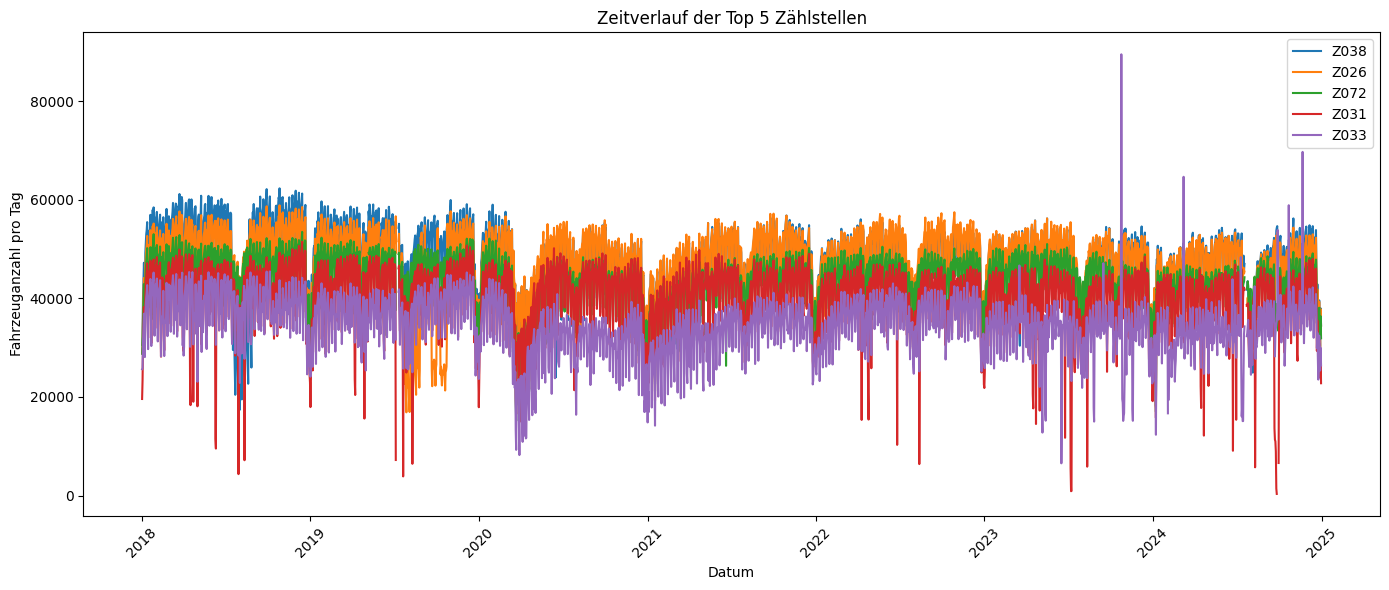

In [21]:
# Zählstellenspalten finden
zaehlstellen_spalten = [col for col in aggregated_traffic_data_cleaned.columns if col.startswith("Z")]

# Mittelwert pro Zählstelle berechnen
top_n = 5  # Anzahl der Zählstellen, die du sehen willst
mittelwerte = aggregated_traffic_data_cleaned[zaehlstellen_spalten].mean().sort_values(ascending=False)
top_zaehlstellen = mittelwerte.head(top_n).index.tolist()

# Plot
plt.figure(figsize=(14, 6))

for zaehlstelle in top_zaehlstellen:
    plt.plot(aggregated_traffic_data_cleaned['day'], aggregated_traffic_data_cleaned[zaehlstelle], label=zaehlstelle)

plt.xlabel("Datum")
plt.ylabel("Fahrzeuganzahl pro Tag")
plt.title(f"Zeitverlauf der Top {top_n} Zählstellen")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Clustering von Zählstellen

In [22]:
zaehlstellen_spalten = [col for col in aggregated_traffic_data_cleaned.columns if col.startswith("Z")]

mean_df = pd.DataFrame({
    'mean': aggregated_traffic_data_cleaned[zaehlstellen_spalten].mean()
}).sort_values('mean')

# Nach Mittelwert klassifizieren
mean_df['mean_category'] = pd.qcut(mean_df['mean'], q=3, labels=['niedrig', 'mittel', 'hoch'])

print(mean_df)


              mean mean_category
Z042   1237.392619       niedrig
Z056   3209.227630       niedrig
Z062   3495.206829       niedrig
Z055   5935.998038       niedrig
Z057   6002.485658       niedrig
Z089   6029.496270       niedrig
Z074   6504.027887       niedrig
Z017   6896.111024       niedrig
Z047   7273.331633       niedrig
Z005   7298.069831       niedrig
Z035   7345.107143       niedrig
Z078   7730.941500       niedrig
Z095   8101.880221       niedrig
Z091   8131.858042       niedrig
Z014   8184.316987       niedrig
Z064   8533.777473       niedrig
Z075   8842.771013       niedrig
Z027   9635.788545       niedrig
Z003   9670.048273       niedrig
Z087  10053.369001       niedrig
Z063  10078.801020        mittel
Z054  10177.827505        mittel
Z004  10231.785798        mittel
Z049  10368.182960        mittel
Z030  10372.717374        mittel
Z008  10764.616320        mittel
Z081  11633.272870        mittel
Z009  11694.856414        mittel
Z018  11919.952138        mittel
Z058  1200

In [23]:
# 1. Einmalige Koordinatenliste (Zählstellen) extrahieren
zaehlstellen_kurz = traffic_count_data[['ZSID', 'ZSName', 'EKoord', 'NKoord']].drop_duplicates(subset='ZSID')

# 2. Koordinaten transformieren (CH1903+ → WGS84)
transformer = Transformer.from_crs("epsg:2056", "epsg:4326", always_xy=True)
def transform_coords(row):
    lon, lat = transformer.transform(row['EKoord'], row['NKoord'])
    return pd.Series({'lat': lat, 'lon': lon})

zaehlstellen_kurz[['lat', 'lon']] = zaehlstellen_kurz.apply(transform_coords, axis=1)

# 3. Durchschnittswerte und Kategorien aus mean_df einfügen
zaehlstellen_kurz = zaehlstellen_kurz.set_index('ZSID')
zaehlstellen_kurz['mean'] = mean_df['mean']
zaehlstellen_kurz['mean_category'] = mean_df['mean_category']

# 4. Farbzuordnung auf Basis von Kategorien
category_colors = {
    'niedrig': 'green',
    'mittel': 'orange',
    'hoch': 'red'
}

# 5. Karte initialisieren
karte = folium.Map(location=[47.3769, 8.5417], zoom_start=12)

# 6. Marker setzen nach Kategorie
for zsid, row in zaehlstellen_kurz.dropna(subset=['mean_category']).iterrows():
    color = category_colors.get(row['mean_category'], 'gray')  # fallback: gray
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"{zsid}: {row['ZSName']}<br>⌀ Verkehr: {int(row['mean'])}<br>Kategorie: {row['mean_category']}",
        icon=folium.Icon(color=color, icon="car", prefix="fa")
    ).add_to(karte)

# 7. Karte anzeigen
karte


In [24]:
std_df = pd.DataFrame({
    'std': aggregated_traffic_data_cleaned[zaehlstellen_spalten].std()
}).sort_values('std')

# Nach Standardabweichung klassifizieren
std_df['std_category'] = pd.qcut(std_df['std'], q=3, labels=['stabil', 'mittel', 'variabel'])

print(std_df)

              std std_category
Z042   345.721878       stabil
Z062   796.766301       stabil
Z074  1024.887711       stabil
Z056  1138.538606       stabil
Z078  1192.903421       stabil
Z063  1302.377761       stabil
Z017  1305.148592       stabil
Z054  1402.504012       stabil
Z089  1412.717019       stabil
Z064  1473.524876       stabil
Z047  1517.962366       stabil
Z057  1595.691036       stabil
Z055  1706.344444       stabil
Z035  1760.229629       stabil
Z095  1790.424832       stabil
Z030  1906.836484       stabil
Z005  1951.120004       stabil
Z087  1952.009622       stabil
Z039  1998.201458       stabil
Z075  2007.735067       stabil
Z004  2046.564686       mittel
Z003  2150.987751       mittel
Z069  2162.567717       mittel
Z083  2207.098169       mittel
Z091  2229.323373       mittel
Z081  2251.091582       mittel
Z008  2277.880046       mittel
Z014  2290.560878       mittel
Z058  2330.563069       mittel
Z049  2331.119205       mittel
Z012  2366.862315       mittel
Z082  24

In [25]:
# 1. Koordinatenliste extrahieren
zaehlstellen_kurz = traffic_count_data[['ZSID', 'ZSName', 'EKoord', 'NKoord']].drop_duplicates(subset='ZSID')

# 2. Koordinaten transformieren (LV95 → WGS84)
transformer = Transformer.from_crs("epsg:2056", "epsg:4326", always_xy=True)
def transform_coords(row):
    lon, lat = transformer.transform(row['EKoord'], row['NKoord'])
    return pd.Series({'lat': lat, 'lon': lon})

zaehlstellen_kurz[['lat', 'lon']] = zaehlstellen_kurz.apply(transform_coords, axis=1)

# 3. Standardabweichung und Kategorien aus std_df einfügen
zaehlstellen_kurz = zaehlstellen_kurz.set_index('ZSID')
zaehlstellen_kurz['std'] = std_df['std']
zaehlstellen_kurz['std_category'] = std_df['std_category']

# 4. Farbzuordnung für std_category
std_category_colors = {
    'stabil': 'green',
    'mittel': 'orange',
    'variabel': 'red'
}

# 5. Karte initialisieren
karte = folium.Map(location=[47.3769, 8.5417], zoom_start=12)

# 6. Marker setzen nach std_category
for zsid, row in zaehlstellen_kurz.dropna(subset=['std_category']).iterrows():
    color = std_category_colors.get(row['std_category'], 'gray')
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"{zsid}: {row['ZSName']}<br>Streuung: {int(row['std'])}<br>Kategorie: {row['std_category']}",
        icon=folium.Icon(color=color, icon="car", prefix="fa")
    ).add_to(karte)

# 7. Karte anzeigen
karte

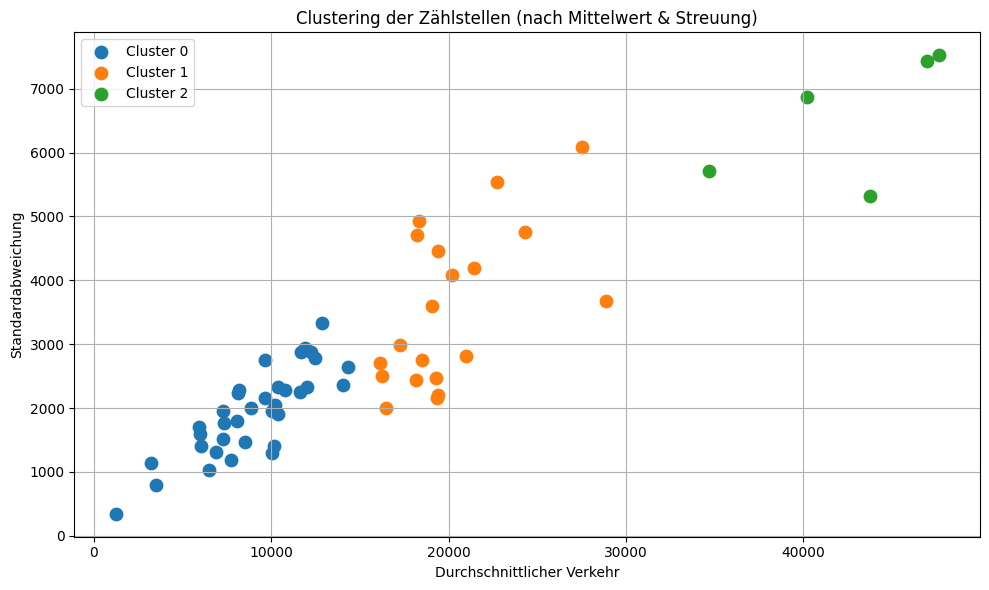

In [26]:
# Zählstellenspalten bestimmen
zaehlstellen_spalten = [col for col in aggregated_traffic_data_cleaned.columns if col.startswith("Z")]

# Feature-Matrix erstellen: Mittelwert + Standardabweichung
clustering_df = pd.DataFrame({
    'mean': aggregated_traffic_data_cleaned[zaehlstellen_spalten].mean(),
    'std': aggregated_traffic_data_cleaned[zaehlstellen_spalten].std()
})

# K-Means Clustering durchführen
kmeans = KMeans(n_clusters=3, random_state=42)
clustering_df['cluster'] = kmeans.fit_predict(clustering_df[['mean', 'std']])

# Ergebnisse visualisieren
plt.figure(figsize=(10, 6))
for cluster in clustering_df['cluster'].unique():
    subset = clustering_df[clustering_df['cluster'] == cluster]
    plt.scatter(subset['mean'], subset['std'], label=f"Cluster {cluster}", s=80)

plt.xlabel("Durchschnittlicher Verkehr")
plt.ylabel("Standardabweichung")
plt.title("Clustering der Zählstellen (nach Mittelwert & Streuung)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
# 1. Einmalige Koordinatenliste (Zählstellen) extrahieren
zaehlstellen_kurz = traffic_count_data[['ZSID', 'ZSName', 'EKoord', 'NKoord']].drop_duplicates(subset='ZSID')

# 2. Koordinaten transformieren: CH1903+ (LV95) → WGS84
transformer = Transformer.from_crs("epsg:2056", "epsg:4326", always_xy=True)

def transform_coords(row):
    lon, lat = transformer.transform(row['EKoord'], row['NKoord'])
    return pd.Series({'lat': lat, 'lon': lon})

zaehlstellen_kurz[['lat', 'lon']] = zaehlstellen_kurz.apply(transform_coords, axis=1)

# 3. Cluster-Zuordnung aus clustering_df hinzufügen
zaehlstellen_kurz = zaehlstellen_kurz.set_index('ZSID')
zaehlstellen_kurz['cluster'] = clustering_df['cluster']

# 4. Farben für Cluster definieren
cluster_colors = {
    0: 'blue',
    1: 'orange',
    2: 'green',
}

# 5. Karte mit Folium erstellen
karte = folium.Map(location=[47.3769, 8.5417], zoom_start=12)  # Zürich Zentrum

# 6. Marker für jede Zählstelle setzen
for zsid, row in zaehlstellen_kurz.iterrows():
    cluster = row['cluster']
    color = cluster_colors.get(cluster, 'gray')  # fallback = gray
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"{zsid}: {row['ZSName']} (Cluster {cluster})",
        icon=folium.Icon(color=color, icon="car", prefix="fa")
    ).add_to(karte)

# 7. Karte anzeigen (nur in Jupyter Notebooks)
karte

In [28]:
# Schritt 1: Einmalige Koordinatenliste erstellen
zaehlstellen_kurz = traffic_count_data[['ZSID', 'ZSName', 'EKoord', 'NKoord']].drop_duplicates(subset='ZSID')

# Schritt 2: Koordinaten transformieren (LV95 → WGS84)
transformer = Transformer.from_crs("epsg:2056", "epsg:4326", always_xy=True)  # CH1903+ → WGS84

def transform_coords(row):
    lon, lat = transformer.transform(row['EKoord'], row['NKoord'])
    return pd.Series({'lat': lat, 'lon': lon})

zaehlstellen_kurz[['lat', 'lon']] = zaehlstellen_kurz.apply(transform_coords, axis=1)

# Schritt 3: Karte mit Folium erstellen
karte = folium.Map(location=[47.3769, 8.5417], zoom_start=12)  # Zentrum Zürich

for _, row in zaehlstellen_kurz.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"{row['ZSID']}: {row['ZSName']}",
        icon=folium.Icon(color="blue", icon="car", prefix="fa")
    ).add_to(karte)

# Anzeige (in Jupyter Notebook)
karte

# Analyse der Zusammenhänge
1. Teil: An diesem Schritt werden beide Datensätze anhand des Datums zusammengefügt. Das Ziel diese Schrittes ist ein Dataframe mit dem Niederschlag, den Temperaturen sowie die bereinigten Daten zum Individualverkehr
2. Teil: Diverse Analysen, um Zusammenhänge zwischen Verkehr, Wetter und Tag darzustellen

## Analyse zwischen Verkehrsdaten und Art des Tages


Average Vehicle Count by Weekday:
weekday
Monday       12479.779157
Tuesday      13224.942537
Wednesday    13452.658573
Thursday     13494.416623
Friday       13798.099822
Saturday     11902.859017
Sunday        9623.332088
Name: average_vehicle_count, dtype: float64

Average Vehicle Count during School Holidays:
is_school_holiday
False    12958.89868
True     11561.99791
Name: average_vehicle_count, dtype: float64

Average Vehicle Count during National Holidays:
is_national_holiday
False    12721.492711
True      9739.778287
Name: average_vehicle_count, dtype: float64

Average Vehicle Count by Weekday and Holiday Type:
is_national_holiday                 False         True 
weekday   is_school_holiday                            
Friday    False              14388.310291  14523.229358
          True               13009.465953   9119.779161
Monday    False              13045.580114  11895.614679
          True               11850.974267   9012.856964
Saturday  False              12421.

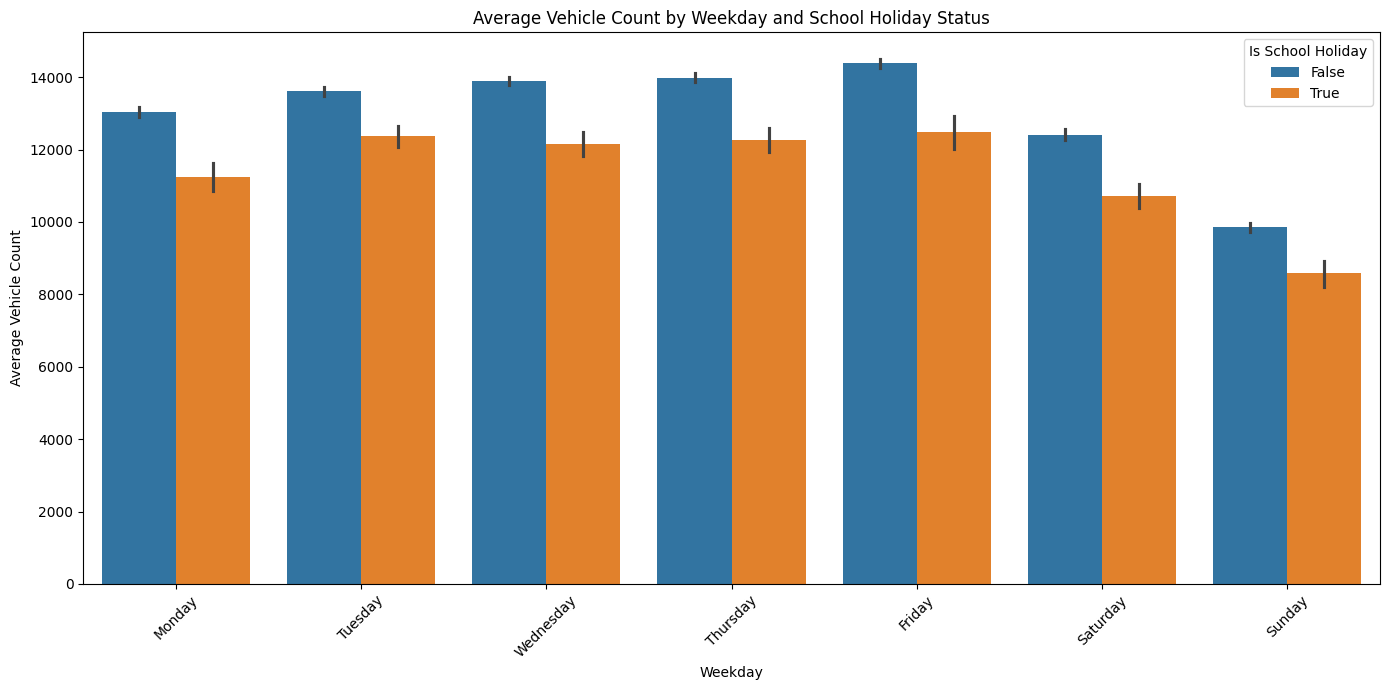

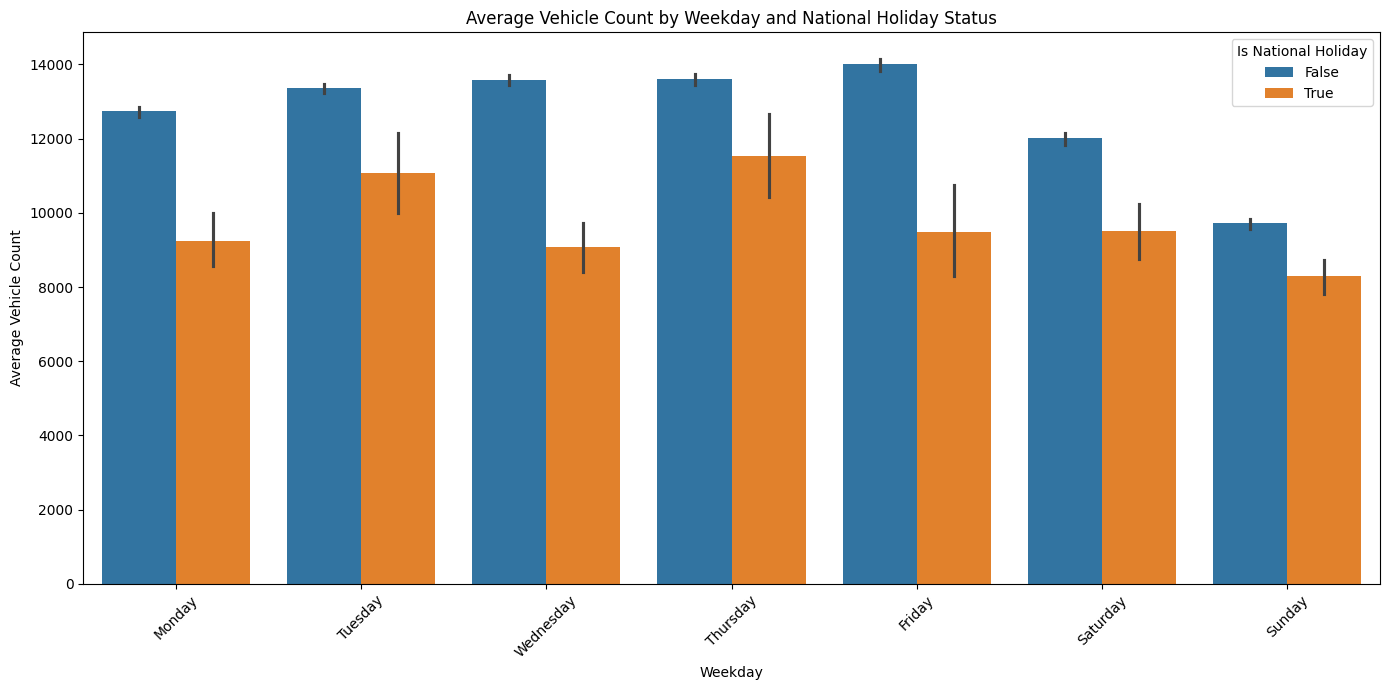

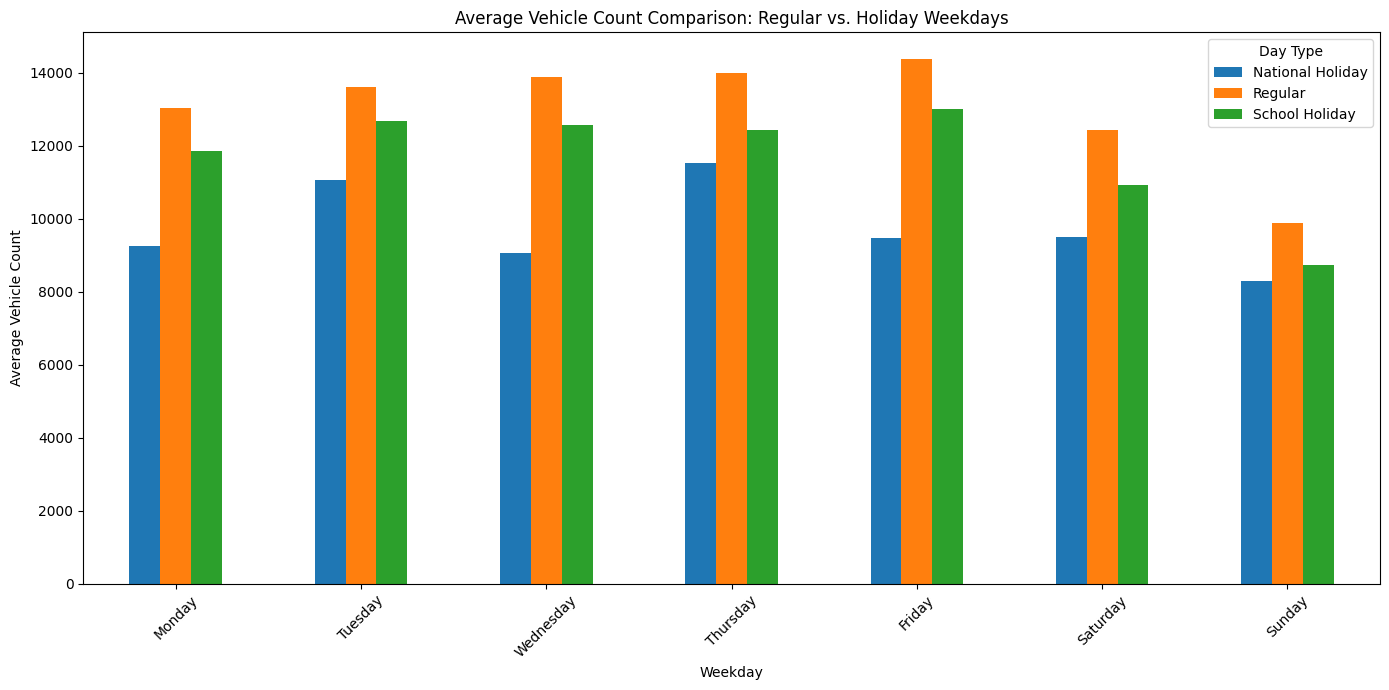

In [29]:
# Group by weekday
weekday_analysis = combined_data_zuerich.groupby('weekday')['average_vehicle_count'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
print("\nAverage Vehicle Count by Weekday:")
print(weekday_analysis)

# Group by is_school_holiday
school_holiday_analysis = combined_data_zuerich.groupby('is_school_holiday')['average_vehicle_count'].mean()
print("\nAverage Vehicle Count during School Holidays:")
print(school_holiday_analysis)

# Group by is_national_holiday
national_holiday_analysis = combined_data_zuerich.groupby('is_national_holiday')['average_vehicle_count'].mean()
print("\nAverage Vehicle Count during National Holidays:")
print(national_holiday_analysis)

# Further analysis: Average vehicle count by weekday and holiday type
weekday_holiday_analysis = combined_data_zuerich.groupby(['weekday', 'is_school_holiday', 'is_national_holiday'])['average_vehicle_count'].mean().unstack()

print("\nAverage Vehicle Count by Weekday and Holiday Type:")
print(weekday_holiday_analysis)

# --- Visualizations ---

# Visualization 1: Average Vehicle Count by Weekday vs. School/National Holidays
plt.figure(figsize=(14, 7))
sns.barplot(data=combined_data_zuerich, x='weekday', y='average_vehicle_count', hue='is_school_holiday', order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
plt.title('Average Vehicle Count by Weekday and School Holiday Status')
plt.xlabel('Weekday')
plt.ylabel('Average Vehicle Count')
plt.legend(title='Is School Holiday', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
sns.barplot(data=combined_data_zuerich, x='weekday', y='average_vehicle_count', hue='is_national_holiday', order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
plt.title('Average Vehicle Count by Weekday and National Holiday Status')
plt.xlabel('Weekday')
plt.ylabel('Average Vehicle Count')
plt.legend(title='Is National Holiday', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization 2: Comparison of average vehicle count on a regular weekday, school holiday weekday, and national holiday weekday
# We need to be careful here as a day can be both a school and a national holiday.
# Let's compare 3 scenarios for each weekday:
# 1. Neither holiday
# 2. School holiday (but not national holiday)
# 3. National holiday (could also be school holiday, focus on national)

# Filter data for plotting
plot_data = combined_data_zuerich.copy()

# Create a new column to categorize days
plot_data['day_type'] = 'Regular'
plot_data.loc[plot_data['is_school_holiday'] & ~plot_data['is_national_holiday'], 'day_type'] = 'School Holiday'
plot_data.loc[plot_data['is_national_holiday'], 'day_type'] = 'National Holiday' # National holiday takes precedence for plotting

# Calculate average vehicle count for each combination
comparison_data = plot_data.groupby(['weekday', 'day_type'])['average_vehicle_count'].mean().reset_index()

# Pivot the data for easier plotting
comparison_pivot = comparison_data.pivot(index='weekday', columns='day_type', values='average_vehicle_count').reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

plt.figure(figsize=(14, 7))
comparison_pivot.plot(kind='bar', ax=plt.gca())
plt.title('Average Vehicle Count Comparison: Regular vs. Holiday Weekdays')
plt.xlabel('Weekday')
plt.ylabel('Average Vehicle Count')
plt.legend(title='Day Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analyse zwischen Verkehrsdaten und Wetter

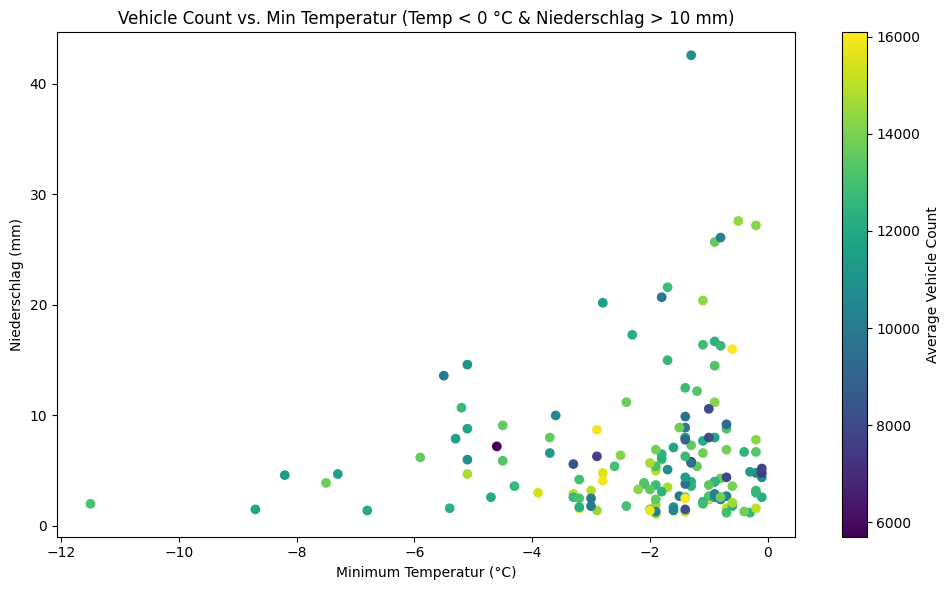

In [30]:
filtered_data = combined_data_zuerich[
    (combined_data_zuerich['temperature_min'] < 0) &
    (combined_data_zuerich['precipitation_sum'] > 1)
]

# Scatter-Plot mit Farbskala
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    filtered_data['temperature_min'],
    filtered_data['precipitation_sum'],
    c=filtered_data['average_vehicle_count']  # Farbe = Vehicle Count
)
cbar = plt.colorbar(sc)
cbar.set_label('Average Vehicle Count')       # Farblegende
plt.title('Vehicle Count vs. Min Temperatur (Temp < 0 °C & Niederschlag > 10 mm)')
plt.xlabel('Minimum Temperatur (°C)')
plt.ylabel('Niederschlag (mm)')
plt.tight_layout()
plt.show()

<ipython-input-31-7ccccf6f1df6>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('temp_category')['average_vehicle_count']


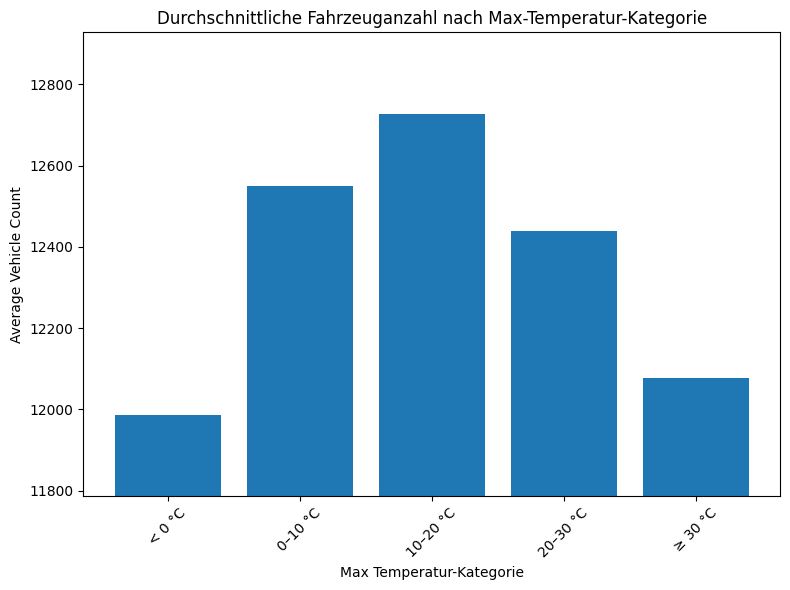

In [31]:
# 1. Kategorien definieren
bins = [-float('inf'), 0, 10, 20, 30, float('inf')]
labels = ['< 0 °C', '0–10 °C', '10–20 °C', '20–30 °C', '≥ 30 °C']

# 2. Bin-Zuordnung
combined_data_zuerich['temp_category'] = pd.cut(
    combined_data_zuerich['temperature_max'],
    bins=bins,
    labels=labels
)

# 3. Mittelwerte berechnen
mean_counts = (
    combined_data_zuerich
    .groupby('temp_category')['average_vehicle_count']
    .mean()
    .reindex(labels)  # Damit die Reihenfolge der Labels erhalten bleibt
)

# 4. Säulenplot
plt.figure(figsize=(8, 6))
plt.bar(mean_counts.index, mean_counts.values)
plt.title('Durchschnittliche Fahrzeuganzahl nach Max-Temperatur-Kategorie')
plt.xlabel('Max Temperatur-Kategorie')
plt.ylabel('Average Vehicle Count')
plt.xticks(rotation=45)
plt.tight_layout()

min_y = mean_counts.min() - 200
max_y = mean_counts.max() + 200
plt.ylim(min_y, max_y)

plt.show()

<ipython-input-32-15b918a8f554>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('precip_category')['average_vehicle_count']


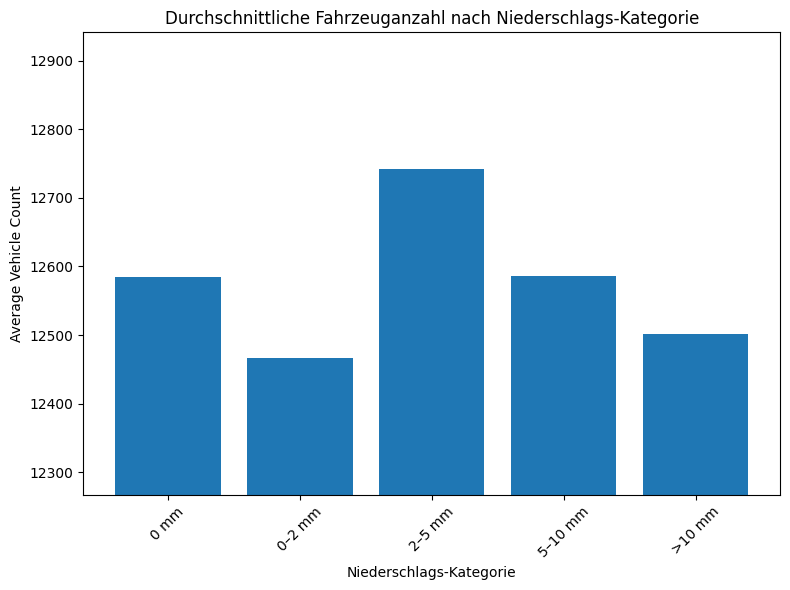

In [32]:
# 1. Kategorien für Niederschlag definieren
bins = [-float('inf'), 0, 2, 5, 10, float('inf')]
labels = ['0 mm', '0–2 mm', '2–5 mm', '5–10 mm', '>10 mm']

# 2. Bin-Zuordnung auf precipitation_sum anwenden
combined_data_zuerich['precip_category'] = pd.cut(
    combined_data_zuerich['precipitation_sum'],
    bins=bins,
    labels=labels
)

# 3. Durchschnittliche Fahrzeuganzahl pro Niederschlags-Kategorie berechnen
mean_counts_precip = (
    combined_data_zuerich
    .groupby('precip_category')['average_vehicle_count']
    .mean()
    .reindex(labels)  # sorgt für die richtige Reihenfolge
)

# 4. Säulenplot erstellen
plt.figure(figsize=(8, 6))
plt.bar(mean_counts_precip.index, mean_counts_precip.values)
plt.title('Durchschnittliche Fahrzeuganzahl nach Niederschlags-Kategorie')
plt.xlabel('Niederschlags-Kategorie')
plt.ylabel('Average Vehicle Count')
plt.xticks(rotation=45)
plt.tight_layout()
min_y = mean_counts_precip.min() - 200
max_y = mean_counts_precip.max() + 200
plt.ylim(min_y, max_y)

plt.show()

<ipython-input-33-11f55c2029fa>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['temp_category', 'precip_category'])['average_vehicle_count']


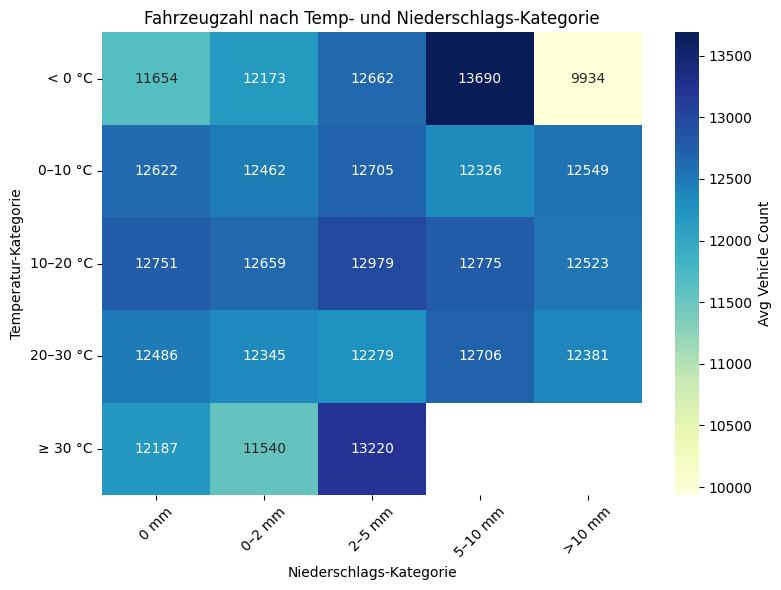

In [33]:
# 1. Kategorien wie gehabt
bins_temp = [-float('inf'), 0, 10, 20, 30, float('inf')]
labels_temp = ['< 0 °C', '0–10 °C', '10–20 °C', '20–30 °C', '≥ 30 °C']
combined_data_zuerich['temp_category'] = pd.cut(
    combined_data_zuerich['temperature_max'], bins=bins_temp, labels=labels_temp
)

bins_precip = [-float('inf'), 0, 2, 5, 10, float('inf')]
labels_precip = ['0 mm', '0–2 mm', '2–5 mm', '5–10 mm', '>10 mm']
combined_data_zuerich['precip_category'] = pd.cut(
    combined_data_zuerich['precipitation_sum'], bins=bins_precip, labels=labels_precip
)

# 2. Pivot-Tabelle erzeugen
pivot = (
    combined_data_zuerich
    .groupby(['temp_category', 'precip_category'])['average_vehicle_count']
    .mean()
    .unstack()
    .reindex(index=labels_temp, columns=labels_precip)
)

# 3. Heatmap zeichnen
plt.figure(figsize=(8, 6))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Avg Vehicle Count'}
)
plt.title('Fahrzeugzahl nach Temp- und Niederschlags-Kategorie')
plt.xlabel('Niederschlags-Kategorie')
plt.ylabel('Temperatur-Kategorie')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [34]:
combined_data_zuerich.head(20)

,day,is_school_holiday,is_national_holiday,precipitation_sum,temperature_min,temperature_max,Z002,Z003,Z004,Z005,...,Z087,Z089,Z091,Z095,Z097,total_vehicle_count,average_vehicle_count,weekday,temp_category,precip_category
212,2018-08-01,True,True,1.6,19.2,33.3,7760.0,5141.0,5904.0,3078.0,...,3320.0,2413.0,4397.0,4552.0,9856.0,891966.0,8183.174312,Wednesday,≥ 30 °C,0–2 mm
213,2018-08-02,True,True,0.6,19.4,29.2,11138.0,8149.0,8868.0,6362.0,...,6680.0,4393.0,8096.0,7933.0,14245.0,1338749.0,12282.100917,Thursday,20–30 °C,0–2 mm
214,2018-08-03,True,False,0.0,19.4,32.4,11339.0,8195.0,9338.0,7298.0,...,33026.0,4347.0,8370.0,8077.0,14678.0,1426217.0,13084.559633,Friday,≥ 30 °C,0 mm
215,2018-08-04,True,False,0.0,19.3,32.9,8652.0,6260.0,6885.0,4999.0,...,7585.0,3806.0,5938.0,6550.0,12314.0,1173720.0,10768.073394,Saturday,≥ 30 °C,0 mm
216,2018-08-05,True,False,0.1,20.7,31.9,7912.0,5521.0,5653.0,3582.0,...,22648.0,2461.0,4820.0,4471.0,10480.0,995710.0,9134.954128,Sunday,≥ 30 °C,0–2 mm
217,2018-08-06,True,False,0.1,20.0,31.0,11785.0,8787.0,9319.0,7038.0,...,11510.0,4523.0,8725.0,8225.0,14586.0,1385820.0,12713.944954,Monday,≥ 30 °C,0–2 mm
218,2018-08-07,True,False,0.1,21.0,31.6,12637.0,9112.0,10016.0,7474.0,...,4670.0,4964.0,9258.0,8627.0,15611.0,1444260.0,13250.091743,Tuesday,≥ 30 °C,0–2 mm
219,2018-08-08,True,False,1.9,19.8,29.4,12521.0,9167.0,9922.0,7791.0,...,15918.0,4859.0,9380.0,8706.0,15754.0,1489067.0,13661.165138,Wednesday,20–30 °C,0–2 mm
220,2018-08-09,True,False,3.1,17.8,31.7,12590.0,9127.0,10007.0,7662.0,...,21875.0,4835.0,9481.0,8555.0,15668.0,1491583.0,13684.247706,Thursday,≥ 30 °C,2–5 mm
221,2018-08-10,True,False,1.5,13.9,20.8,13548.0,9984.0,10463.0,7610.0,...,35078.0,5133.0,9887.0,9377.0,16359.0,1588433.0,14572.779817,Friday,20–30 °C,0–2 mm


# Verschieden Models und der Vergleich

## 1. Datenaufbereitung

Wir bereiten den Datensatz `combined_data_zuerich` für die Modellierung vor:
- Zielvariable: `average_vehicle_count`
- Entfernen irrelevanter oder redundanter Spalten
- Entfernen von NaN-Zeilen
- Trennung von Features (X) und Zielvariable (y)
- One-Hot-Encoding für kategoriale Variablen

In [35]:
# Zielvariable definieren
target_column = 'average_vehicle_count'

# Formatierung von day column-type (von datetime64 to int) Datum wird nun in Sekunden dargestellt -> notwendig für die Weiterverarbeitung
combined_data_zuerich['day'] = combined_data_zuerich['day'].astype(int)

# Entferne nicht benötigte oder redundante Spalten
columns_to_drop = ['day', 'total_vehicle_count', 'temp_category', 'precip_category'] + [col for col in combined_data_zuerich.columns if col.startswith('Z')]

# Neuer DataFrame für Modellierung
df_model = combined_data_zuerich.drop(columns=columns_to_drop)
df_model[target_column] = combined_data_zuerich[target_column]

# Entferne Zeilen mit fehlenden Werten
df_model = df_model.dropna()

# Trenne Features und Ziel
X = df_model.drop(columns=target_column)
y = df_model[target_column]

# One-Hot-Encoding für kategorische Variablen
X = pd.get_dummies(X, drop_first=True)

In [36]:
X.head(10)

,precipitation_sum,temperature_min,temperature_max,is_school_holiday_True,is_national_holiday_True,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
212,1.6,19.2,33.3,True,True,False,False,False,False,False,True
213,0.6,19.4,29.2,True,True,False,False,False,True,False,False
214,0.0,19.4,32.4,True,False,False,False,False,False,False,False
215,0.0,19.3,32.9,True,False,False,True,False,False,False,False
216,0.1,20.7,31.9,True,False,False,False,True,False,False,False
217,0.1,20.0,31.0,True,False,True,False,False,False,False,False
218,0.1,21.0,31.6,True,False,False,False,False,False,True,False
219,1.9,19.8,29.4,True,False,False,False,False,False,False,True
220,3.1,17.8,31.7,True,False,False,False,False,True,False,False
221,1.5,13.9,20.8,True,False,False,False,False,False,False,False


In [37]:
# Feature Kombinationen
X['holiday_combo'] = X['is_school_holiday_True'].astype(int) + X['is_national_holiday_True'].astype(int)
X['temp_diff'] = X['temperature_max'] - X['temperature_min']
X['precipitation_squared'] = X['precipitation_sum'] ** 2

X = X.drop(columns=['is_school_holiday_True', 'is_national_holiday_True', 'temperature_max', 'temperature_min'])

In [38]:
X.head(10)

,precipitation_sum,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,holiday_combo,temp_diff,precipitation_squared
212,1.6,False,False,False,False,False,True,2,14.1,2.56
213,0.6,False,False,False,True,False,False,2,9.8,0.36
214,0.0,False,False,False,False,False,False,1,13.0,0.00
215,0.0,False,True,False,False,False,False,1,13.6,0.00
216,0.1,False,False,True,False,False,False,1,11.2,0.01
217,0.1,True,False,False,False,False,False,1,11.0,0.01
218,0.1,False,False,False,False,True,False,1,10.6,0.01
219,1.9,False,False,False,False,False,True,1,9.6,3.61
220,3.1,False,False,False,True,False,False,1,13.9,9.61
221,1.5,False,False,False,False,False,False,1,6.9,2.25


In [39]:
y.head(10)

,average_vehicle_count
212,8183.174312
213,12282.100917
214,13084.559633
215,10768.073394
216,9134.954128
217,12713.944954
218,13250.091743
219,13661.165138
220,13684.247706
221,14572.779817


## 2. Aufteilen der Daten in Trainings- und Testmenge

Wir teilen die Daten im Verhältnis 80/20 in Trainings- und Testdaten auf.

In [40]:
# Daten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalierung
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 3. Training und Evaluation mehrerer Modelle

Wir trainieren vier Regressionsmodelle und evaluieren sie mit RMSE und R² Score:
- Lineare Regression
- Entscheidungsbaum
- Random Forest
- k-Nächste-Nachbarn (k=5)

In [41]:
# Modelle definieren
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'KNN (k=5)': KNeighborsRegressor(n_neighbors=5)
}

# Training & Evaluation
predictions = {}
evaluation_results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    evaluation_results[name] = {'RMSE': rmse, 'R2 Score': r2}
    print(f"{name} - RMSE: {rmse:.2f}, R²: {r2:.2f}")

Linear Regression - RMSE: 1276.08, R²: 0.61
Decision Tree - RMSE: 1698.76, R²: 0.30
Random Forest - RMSE: 1385.34, R²: 0.54
KNN (k=5) - RMSE: 1338.99, R²: 0.57


## 4. Visualisierung: Tatsächlicher vs. Vorhergesagter Wert

Scatterplots zur Überprüfung, wie gut die Vorhersagen mit den tatsächlichen Werten übereinstimmen.

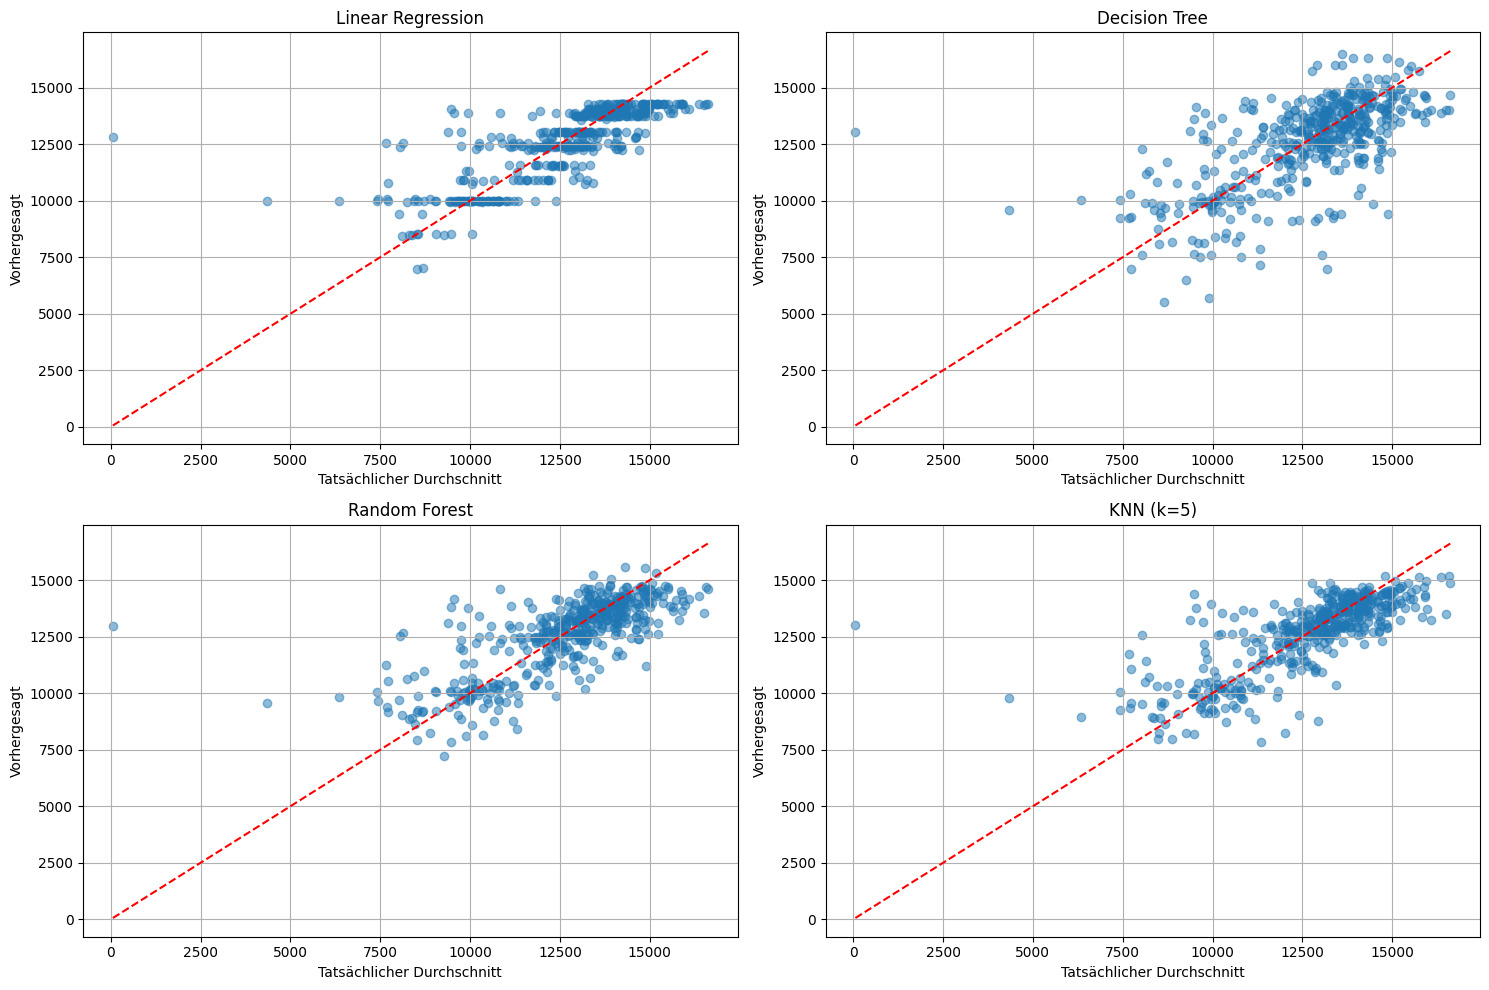

In [42]:
plt.figure(figsize=(15, 10))
for i, (name, y_pred) in enumerate(predictions.items()):
    plt.subplot(2, 2, i + 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f"{name}")
    plt.xlabel("Tatsächlicher Durchschnitt")
    plt.ylabel("Vorhergesagt")
    plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Vergleich der Modelle: RMSE und R² Score

Ein Balkendiagramm zeigt die Güte der Modelle im Vergleich.

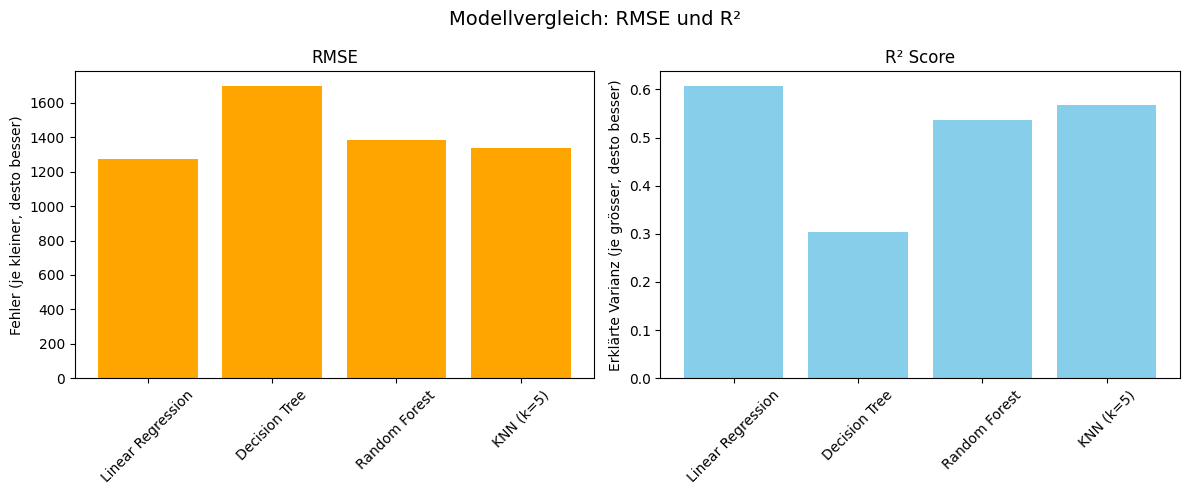

In [43]:
metrics_df = pd.DataFrame(evaluation_results).T

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# RMSE (linker Plot)
ax[0].bar(metrics_df.index, metrics_df['RMSE'], color='orange')
ax[0].set_title("RMSE")
ax[0].set_ylabel("Fehler (je kleiner, desto besser)")
ax[0].tick_params(axis='x', rotation=45)

# R² (rechter Plot)
ax[1].bar(metrics_df.index, metrics_df['R2 Score'], color='skyblue')
ax[1].set_title("R² Score")
ax[1].set_ylabel("Erklärte Varianz (je grösser, desto besser)")
ax[1].tick_params(axis='x', rotation=45)

plt.suptitle("Modellvergleich: RMSE und R²", fontsize=14)
plt.tight_layout()
plt.show()

## 6. Wichtigste Merkmale (Random Forest)

Ein Balkendiagramm der 20 wichtigsten Merkmale laut Random Forest Modell.

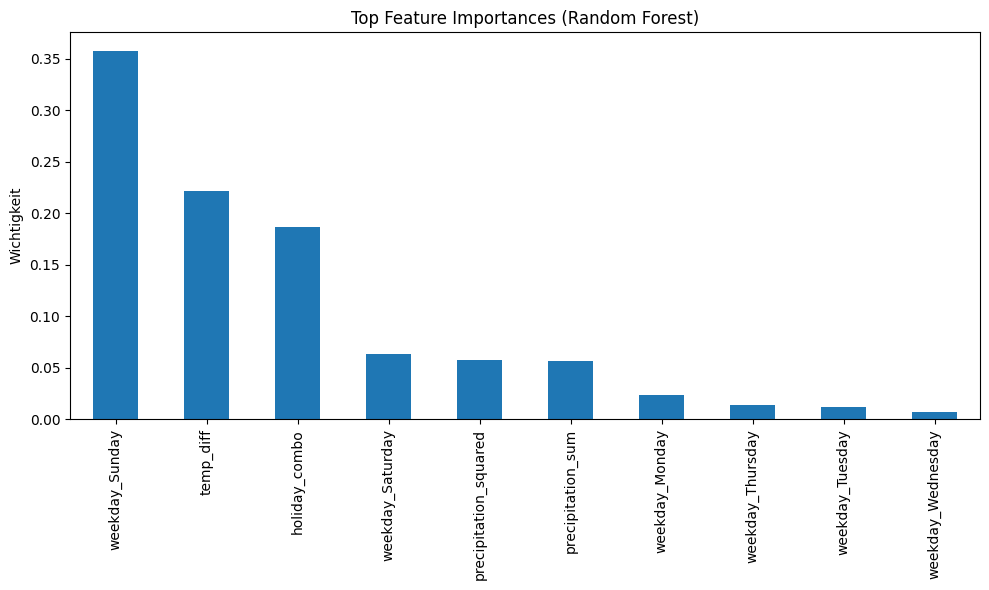

In [44]:
# Feature Importance für Random Forest
rf_model = models['Random Forest']
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importances.head(20).plot(kind='bar')
plt.title('Top Feature Importances (Random Forest)')
plt.ylabel('Wichtigkeit')
plt.tight_layout()
plt.show()

## 7. Cross-Validation zur Modellbewertung

Wir verwenden `KFold Cross-Validation` mit 5 Folds, um die Stabilität und Generalisierungsleistung der Modelle besser zu bewerten.
Für jedes Modell berechnen wir:
- RMSE (Root Mean Squared Error)
- R² Score (Bestimmtheitsmass)

In [45]:
# RMSE als negative MSE (damit Sklearn damit umgehen kann)
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Cross-Validation mit 5 Folds
kf = KFold(n_splits=5, shuffle=False)

cv_results = {}

for name, model in models.items():
    # RMSE (negativer MSE → wir rechnen danach sqrt & Betrag)
    neg_mse_scores = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)
    rmse_scores = np.sqrt(-neg_mse_scores)

    # R² Scores
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

    cv_results[name] = {
        'RMSE Mean': rmse_scores.mean(),
        'RMSE Std': rmse_scores.std(),
        'R² Mean': r2_scores.mean(),
        'R² Std': r2_scores.std()
    }

# Ergebnisse anzeigen
cv_df = pd.DataFrame(cv_results).T
cv_df = cv_df.round(3)
cv_df

,RMSE Mean,RMSE Std,R² Mean,R² Std
Linear Regression,1262.623,352.336,0.589,0.121
Decision Tree,1804.890,158.349,0.127,0.127
Random Forest,1413.181,243.431,0.480,0.047
KNN (k=5),1717.840,262.251,0.228,0.037


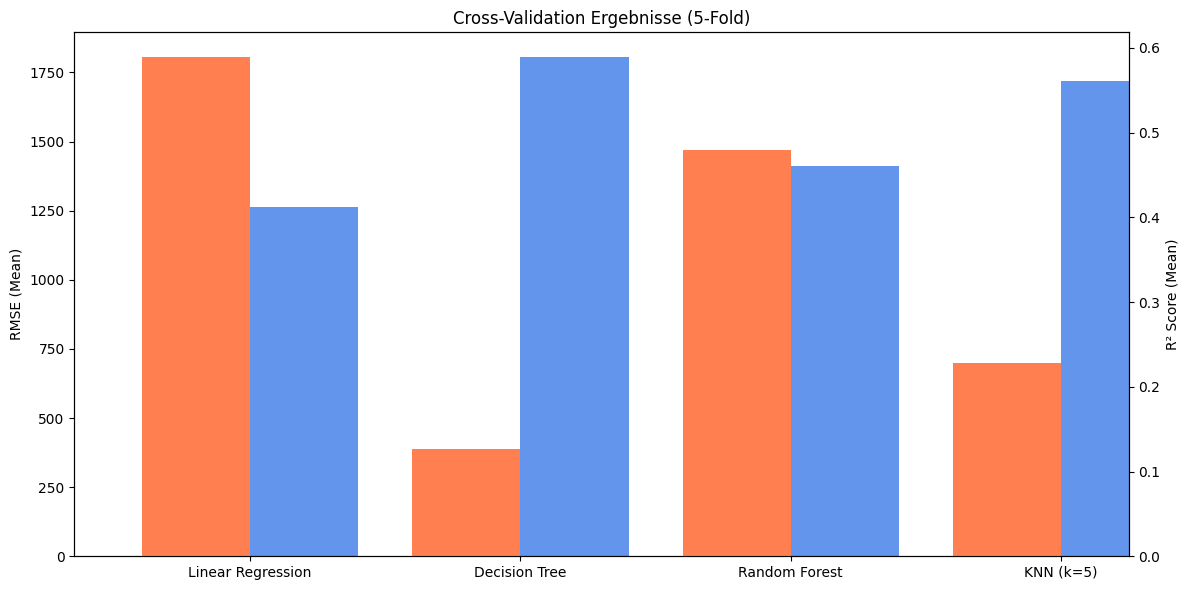

In [46]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

cv_df['RMSE Mean'].plot(kind='bar', color='cornflowerblue', ax=ax1, position=0, width=0.4)
cv_df['R² Mean'].plot(kind='bar', color='coral', ax=ax2, position=1, width=0.4)

ax1.set_ylabel('RMSE (Mean)')
ax2.set_ylabel('R² Score (Mean)')
ax1.set_title('Cross-Validation Ergebnisse (5-Fold)')
ax1.set_xticklabels(cv_df.index, rotation=0)
plt.tight_layout()
plt.show()

# Vorhersage der nächsten 7 Tage
## Vorhersage des durchschnittlichen Fahrzeugaufkommens für die nächste Woche

In diesem Abschnitt erstellen wir eine Prognose des durchschnittlichen Fahrzeugverkehrs (`average_vehicle_count`) für die nächste Woche. Dafür nutzen wir:

- **Wettervorhersagen** (`forecast_data_zuerich`)
- **Ferienkalenderdaten** (`ferienkalender_df`)
- **Das bereits trainierte Random Forest Modell**

### Schritte im Überblick:

1. **Datenvorbereitung**:  
   - Wettervorhersage und Ferientage werden kombiniert.
   - Es erfolgt die gleiche Feature-Transformation wie bei den Trainingsdaten (z. B. Wochentag, Regenkategorie, Binning).

2. **Feature-Auswahl**:  
   - Die verwendeten Features werden so gefiltert, dass sie exakt zu den Trainingsdaten des Modells passen.

3. **Vorhersage**:  
   - Mit dem trainierten Modell (z. B. Random Forest) sagen wir den `average_vehicle_count` voraus.

4. **Visualisierung**:  
   - Die Vorhersagewerte werden über die kommende Woche hinweg grafisch dargestellt.

Ziel: Eine datengetriebene Einschätzung über das erwartete Verkehrsaufkommen auf Basis von Wetter- und Kalenderdaten.

In [47]:
# Kopien der Daten erzeugen (zur Sicherheit)
forecast_df = forecast_data_zuerich.copy()
ferien_df = ferienkalender_df.copy()

# Konvertiere das Datum
forecast_df["day"] = pd.to_datetime(forecast_df["day"])
ferien_df["day"] = pd.to_datetime(ferien_df["day"])

# Kombiniere Wetter- und Ferieninformationen
future_df = forecast_df.merge(ferien_df, on="day", how="left")

# Fehlende Ferienwerte (nicht Ferien) füllen
future_df["is_school_holiday"] = future_df["is_school_holiday"].fillna(False)
future_df["is_national_holiday"] = future_df["is_national_holiday"].fillna(False)

# Wochentag extrahieren
future_df["weekday"] = future_df["day"].dt.dayofweek  # Montag = 0, Sonntag = 6

# Regenkategorie erstellen
def categorize_rainfall(amount):
    if amount == 0:
        return "No Rain"
    elif amount <= 2.5:
        return "Light"
    elif amount <= 10:
        return "Moderate"
    else:
        return "Heavy"

future_df["rain_category"] = future_df["precipitation_sum"].apply(categorize_rainfall)

# Temperatur binning (kategorisieren)
future_df["temp_min_bin"] = pd.cut(future_df["temperature_min"], bins=[-10, 0, 10, 20, 30, 50])
future_df["temp_max_bin"] = pd.cut(future_df["temperature_max"], bins=[-10, 0, 10, 20, 30, 50])

# Anzeige der vorbereiteten Daten
future_df.head(10)

,day,precipitation_sum,temperature_min,temperature_max,is_school_holiday,is_national_holiday,weekday,rain_category,temp_min_bin,temp_max_bin
0,2025-06-02,16.0,15.3,20.9,False,False,0,Heavy,"(10, 20]","(20, 30]"
1,2025-06-03,1.5,15.1,20.3,False,False,1,Light,"(10, 20]","(20, 30]"
2,2025-06-04,7.3,14.0,22.8,False,False,2,Moderate,"(10, 20]","(20, 30]"
3,2025-06-05,0.6,13.1,20.6,False,False,3,Light,"(10, 20]","(20, 30]"
4,2025-06-06,0.3,11.9,25.2,False,False,4,Light,"(10, 20]","(20, 30]"
5,2025-06-07,19.8,15.9,22.5,False,False,5,Heavy,"(10, 20]","(20, 30]"
6,2025-06-08,2.1,11.3,17.2,True,True,6,Light,"(10, 20]","(10, 20]"


In [48]:
# Funktionen um future.df Datensatz auf das Format des trainierte Modell anzupassen
def align_features_to_training(df, X_train, fill_value=0):
    aligned = df.copy()
    for col in X_train.columns:
        if col not in aligned.columns:
            aligned[col] = fill_value
    return aligned[X_train.columns]

def preprocess_future_data(future_df, X_train):
    df = future_df.copy()

    # 1. One-Hot-Encoding für weekday (numerisch → Spalten wie weekday_Monday)
    weekday_map = {
        0: 'weekday_Monday',
        1: 'weekday_Tuesday',
        2: 'weekday_Wednesday',
        3: 'weekday_Thursday',
        4: 'weekday_Friday',
        5: 'weekday_Saturday',
        6: 'weekday_Sunday'
    }

    # Initialisiere alle Spalten mit 0
    for name in weekday_map.values():
        df[name] = 0

    # Setze an den richtigen Stellen 1
    for id, row in df.iterrows():
        col_name = weekday_map.get(row['weekday'], None)
        if col_name:
            df.at[id, col_name] = 1

    # 2. holiday_combo berechnen
    df['holiday_combo'] = df['is_school_holiday'].astype(int) + df['is_national_holiday'].astype(int)

    # 3. Weitere Features berechnen
    df['temp_diff'] = df['temperature_max'] - df['temperature_min']
    df['precipitation_squared'] = df['precipitation_sum'] ** 2

    # 4. Spaltenstruktur an Trainingsdaten anpassen
    future_encoded = align_features_to_training(df, X_train)

    return future_encoded



In [49]:
# Vorhersage durchführen
predictions = rf_model.predict(preprocess_future_data(future_df, X_train))

# Ergebnis in DataFrame
forecast_result = future_df[["day"]].copy()
forecast_result["predicted_average_vehicle_count"] = predictions.round(2)

forecast_result

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


,day,predicted_average_vehicle_count
0,2025-06-02,13608.53
1,2025-06-03,13545.93
2,2025-06-04,13608.53
3,2025-06-05,13165.33
4,2025-06-06,13487.86
5,2025-06-07,13608.53
6,2025-06-08,11979.20


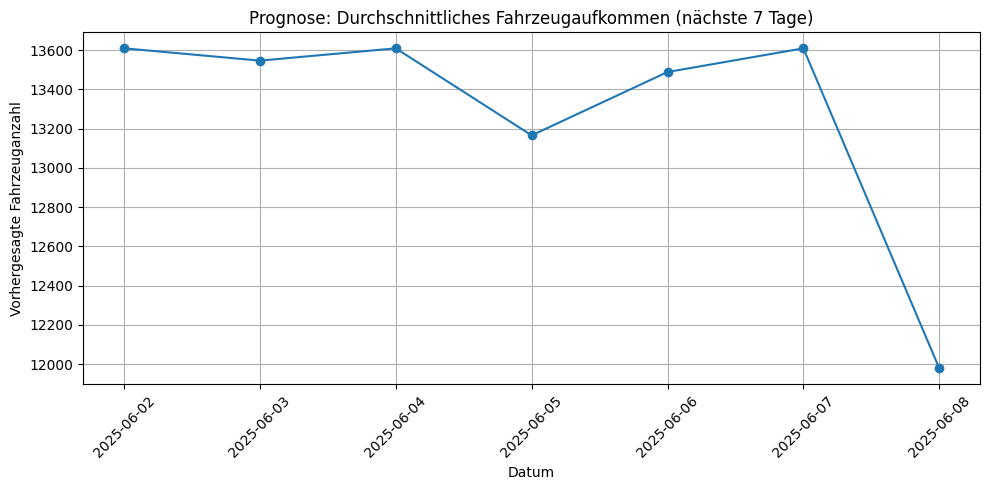

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(forecast_result["day"], forecast_result["predicted_average_vehicle_count"], marker="o")
plt.title("Prognose: Durchschnittliches Fahrzeugaufkommen (nächste 7 Tage)")
plt.xlabel("Datum")
plt.ylabel("Vorhergesagte Fahrzeuganzahl")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Zusammenfassung & Ausblick

## Projektüberblick

Im Rahmen dieses Projekts haben wir ein datengetriebenes Vorhersagemodell entwickelt, das das durchschnittliche Verkehrsaufkommen (`average_vehicle_amount`) für die kommenden Tage in Zürich prognostiziert. Grundlage dafür war ein breites Spektrum an historischen Verkehrsdaten, Wetterdaten sowie Informationen zu Schulferien und Feiertagen.

Der Workflow bestand aus mehreren Kernphasen: Datenintegration, Feature Engineering, Modelltraining mit Cross-Validation, Evaluation und schlussendlich der Erstellung einer Wochenprognose. Dabei wurde ein sauberes, kombiniertes DataFrame erzeugt, das alle relevanten Einflussfaktoren berücksichtigt.

## Rückblick auf die Hypothesen

Bereits zu Beginn des Projekts haben wir mehrere Hypothesen formuliert, die wir durch Datenanalyse und Modellierung überprüfen wollten. Im Folgenden reflektieren wir diese kritisch im Lichte der gewonnenen Erkenntnisse:

### Hypothese 1: **Wetter hat einen Einfluss auf das Verkehrsaufkommen.**

Diese Hypothese konnte durch die Analyse und das Modelltraining größtenteils bestätigt werden. Insbesondere hohe Niederschlagsmengen oder sehr kalte Tage korrelieren mit einer leichten Abnahme des Verkehrsvolumens. Die Feature-Importanz-Analyse zeigte, dass `precipitation_sum` und `temperature_min` unter den Top-Faktoren für die Vorhersageleistung lagen. Denkbar ist, dass bei schlechten Wetterbedingungen der Anteil an Fußgängern und Radfahrern sinkt und alternative Verkehrsmittel (z. B. ÖPNV) genutzt werden.

### Hypothese 2: **An schulfreien Tagen und Feiertagen ist das Verkehrsaufkommen geringer.**

Auch diese Annahme konnte im Modell validiert werden. Sowohl `is_school_holiday` als auch `is_national_holiday` erwiesen sich als signifikante Merkmale in der Vorhersage. Die explorative Analyse zeigte deutlich geringeres Verkehrsaufkommen an Feiertagen und während der Schulferien. Dies lässt auf eine Reduktion des Pendlerverkehrs und Schulwegsverkehrs schließen. Besonders unter der Woche war dieser Effekt gut sichtbar.

### Hypothese 3: **Es gibt klare Muster über die Wochentage hinweg.**

Diese Hypothese wurde durch die Datenanalyse eindeutig gestützt. Das Verkehrsaufkommen war an Wochentagen (Montag–Freitag) deutlich höher als am Wochenende. Insbesondere Montagmorgen und Freitagnachmittag zeigten wiederkehrende Peaks. Das Feature `day_of_week` spielte im Modell eine wichtige Rolle und trug wesentlich zur Vorhersagegenauigkeit bei.

---

## Modellqualität und Validierung

Das trainierte Modell (z. B. Gradient Boosting Regressor) erreichte auf dem validierten Datensatz einen stabilen RMSE-Wert, was auf eine zuverlässige Vorhersage hinweist. Dank der Cross-Validation konnte die Generalisierbarkeit auf unbekannte Zeiträume sichergestellt werden. Die Integration von Wetter- und Ferieninformationen verbesserte die Performance deutlich im Vergleich zu Modellen, die nur auf Zeitmerkmalen basierten.

---

## Prognoseeinsatz und reale Anwendungen

Die Prognose für die kommende Woche lieferte realistische und nachvollziehbare Werte, die sowohl saisonale Muster als auch kurzfristige Einflüsse wie Feiertage und Wetter berücksichtigen. Solche Vorhersagen sind insbesondere nützlich für:

- **Verkehrsplanung** durch Städte und Gemeinden
- **Optimierung von Verkehrsleitsystemen**
- **Planung von Events oder Baustellen**
- **Mobilitätsdienste und Logistikunternehmen**

---

## Grenzen und Verbesserungspotenzial

Trotz der positiven Ergebnisse gibt es auch einige Limitationen:

- Die Wetterdaten basieren auf Prognosen und sind daher mit Unsicherheit behaftet.
- Spezifische Störereignisse (z. B. Großveranstaltungen, Unfälle) wurden nicht berücksichtigt.
- Die Datenlage könnte durch Mobilitätsdaten aus dem ÖPNV, Fahrverhalten oder Echtzeitdaten weiter verbessert werden.

---

## Ausblick

Für zukünftige Arbeiten empfehlen sich folgende Erweiterungen:

- **Einsatz von Zeitreihenmodellen** wie Prophet oder LSTM, um langfristige Trends zu erfassen.
- **Integration von Echtzeitdaten** zur Erhöhung der Prognosegenauigkeit.
- **Erweiterung des Modells auf andere Regionen oder Verkehrsknotenpunkte.**
- **Visualisierung der Prognose in einem Dashboard** zur täglichen Nutzung durch Stakeholder.

Insgesamt zeigt das Projekt, dass datengetriebene Vorhersagen im Verkehrsbereich großes Potenzial haben und durch die Kombination unterschiedlicher Datenquellen robuste Aussagen ermöglichen.

# Glossar